In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
print("Libraries imported successfully.\n")

Libraries imported successfully.



In [2]:
# Load Data
df = pd.read_csv('train_data.csv')
print(f"Training data loaded with shape: {df.shape}\n")

Training data loaded with shape: (5807, 97)



In [3]:
y = df['Bankrupt?']
idx_col = df['Index'].copy()
X_raw = df.drop(columns=['Bankrupt?', 'Index'])
print(f"Features shape after dropping Index and Target: {X_raw.shape}\n")


Features shape after dropping Index and Target: (5807, 95)



In [4]:
# Gaussian Transformation 
print("Applying PowerTransformer (Yeo-Johnson) to make features Gaussian...")
pt = PowerTransformer(method='yeo-johnson')
X_gauss = pd.DataFrame(pt.fit_transform(X_raw), columns=X_raw.columns)
print("Transformation applied.\n")

Applying PowerTransformer (Yeo-Johnson) to make features Gaussian...
Transformation applied.



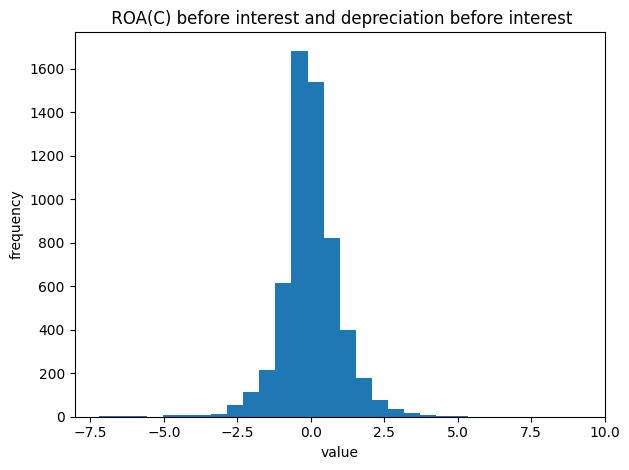

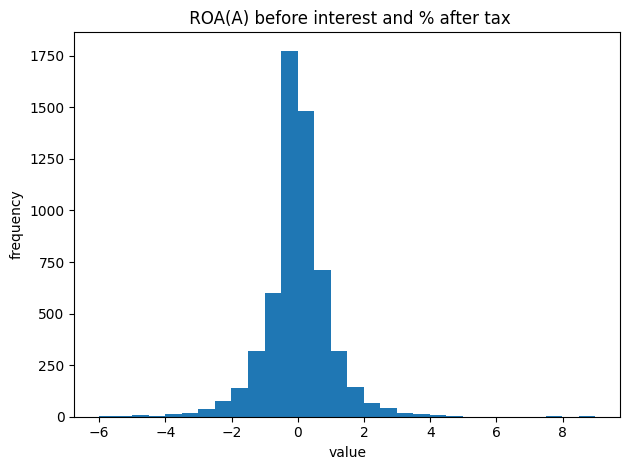

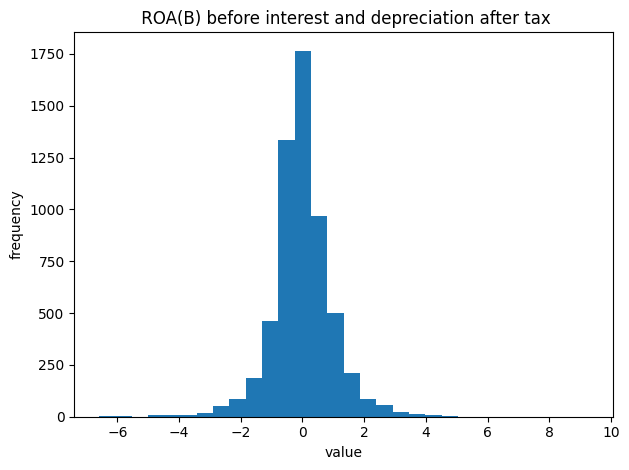

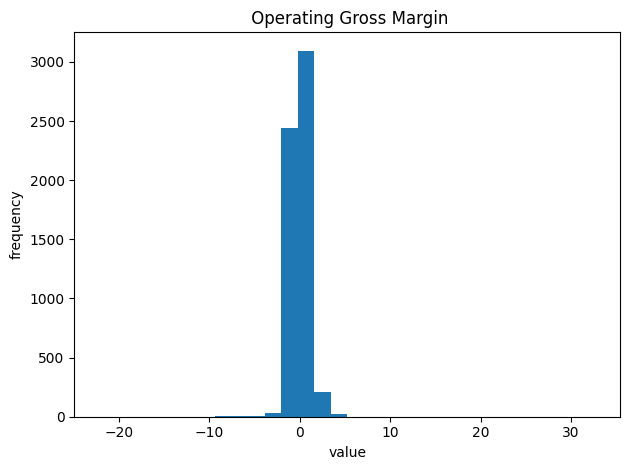

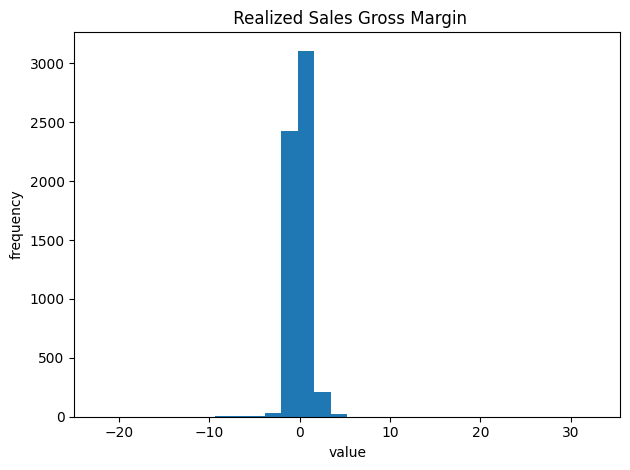

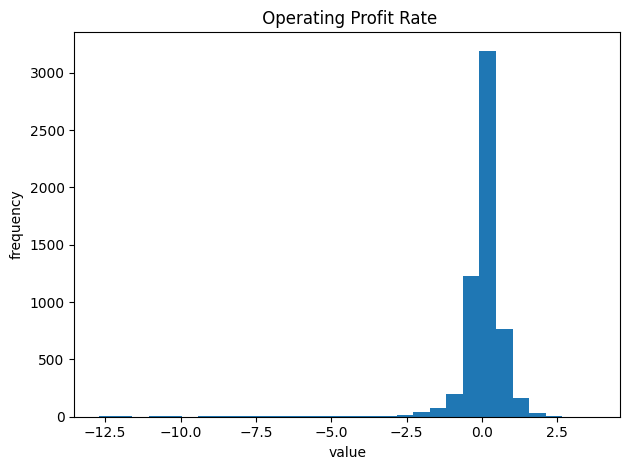

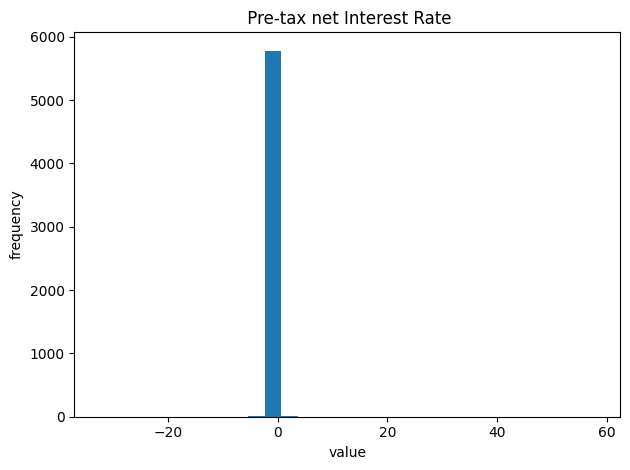

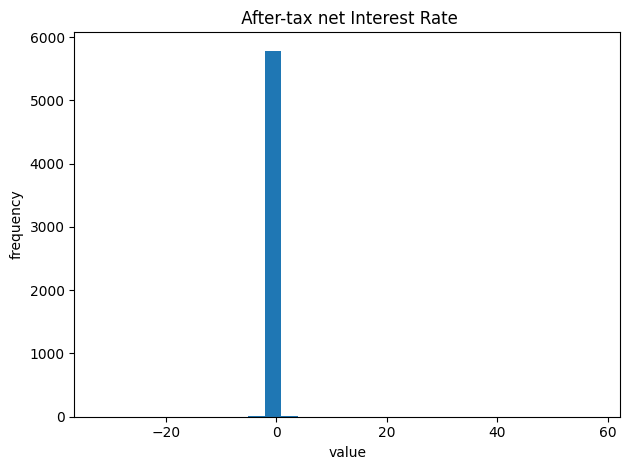

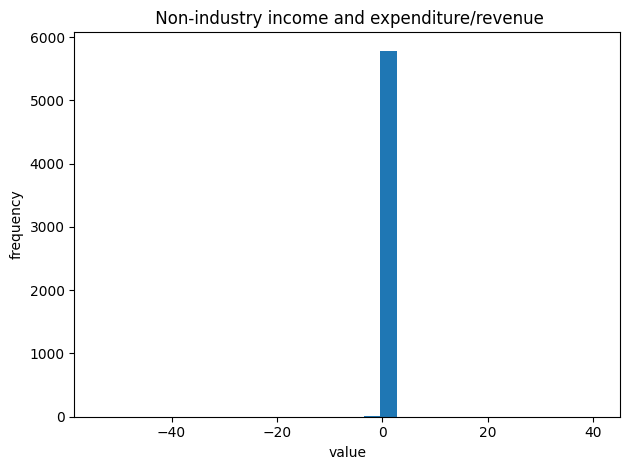

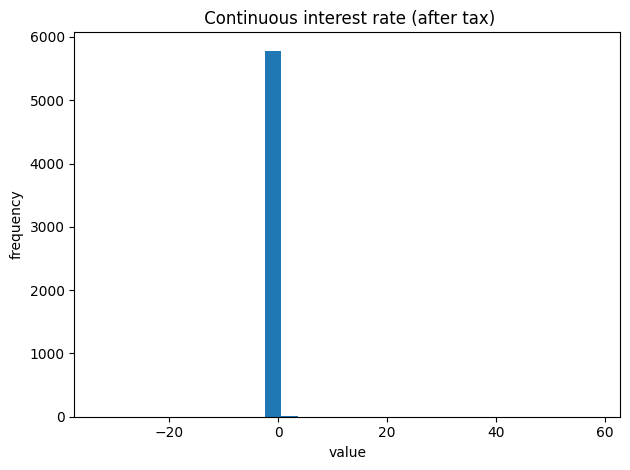

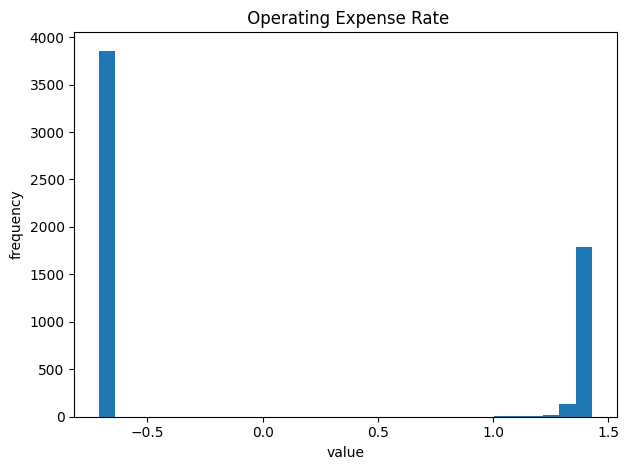

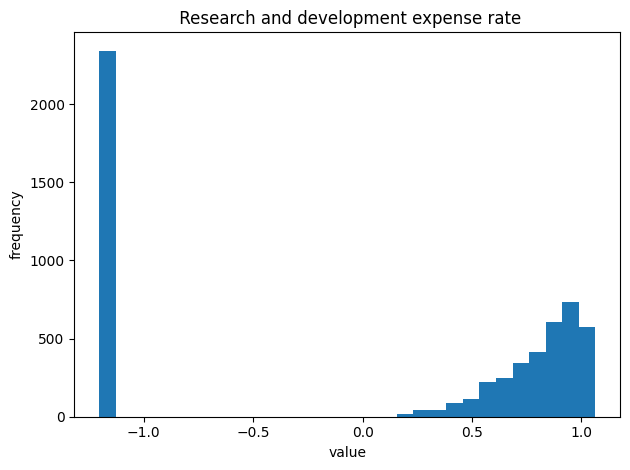

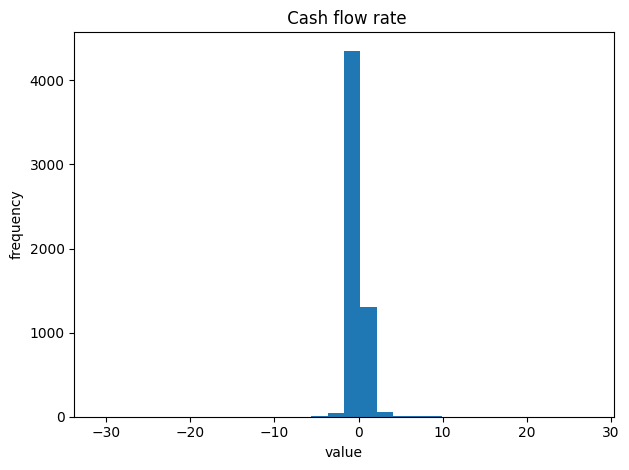

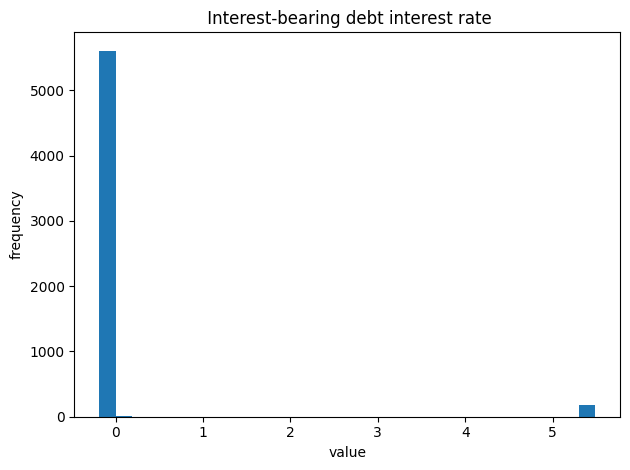

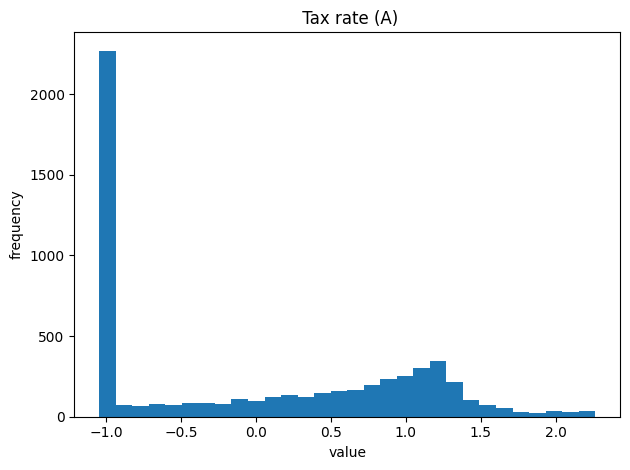

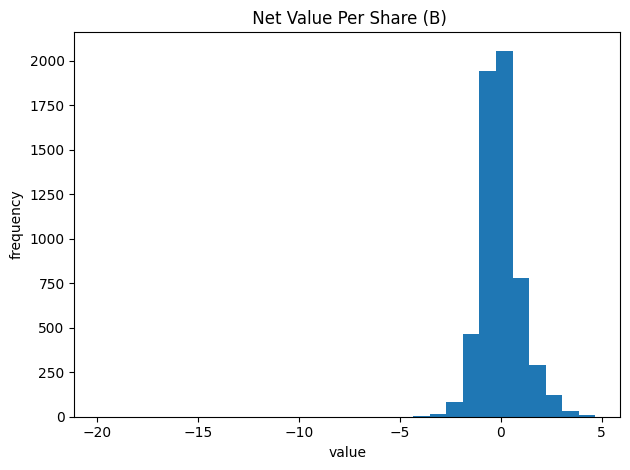

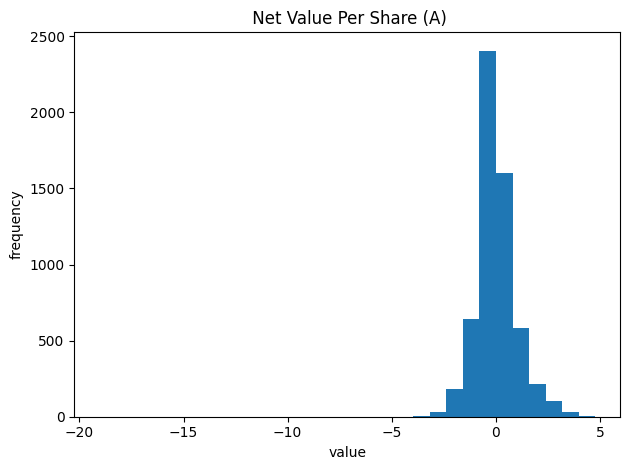

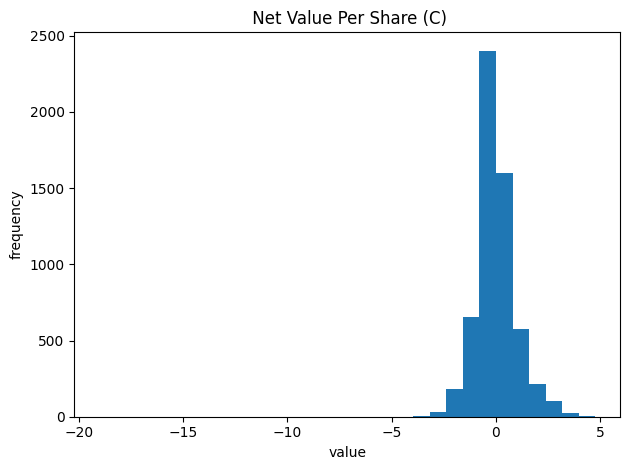

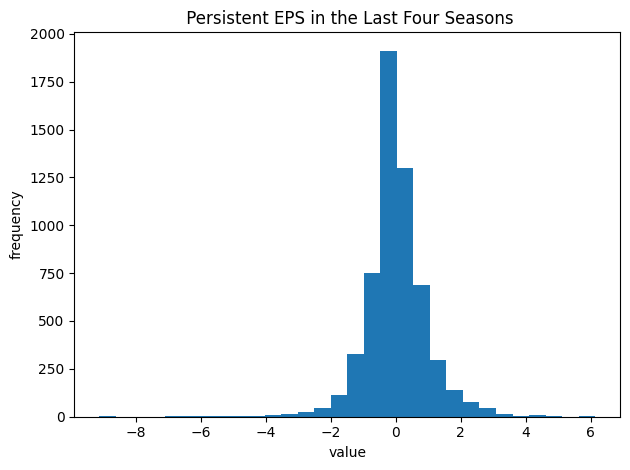

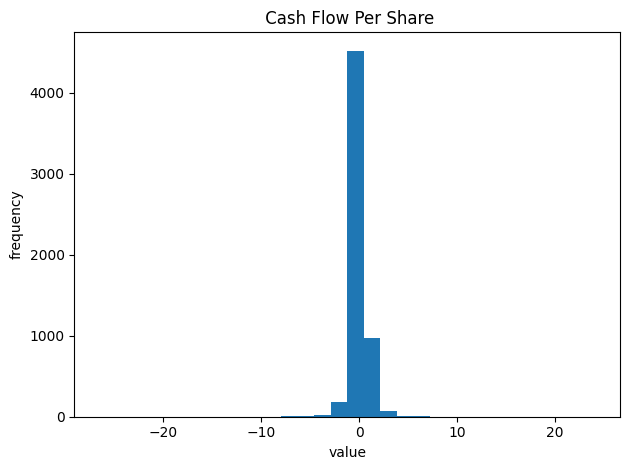

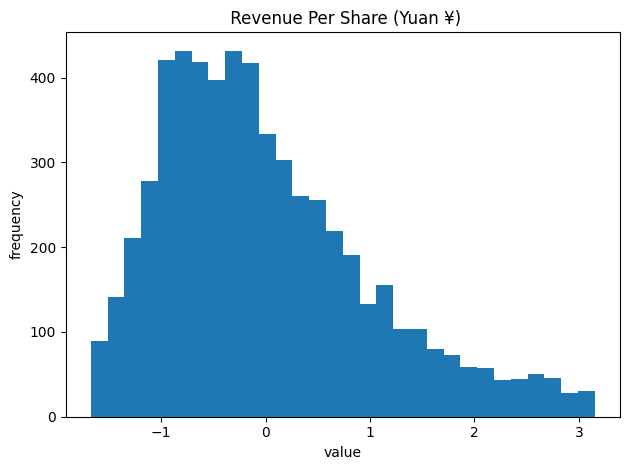

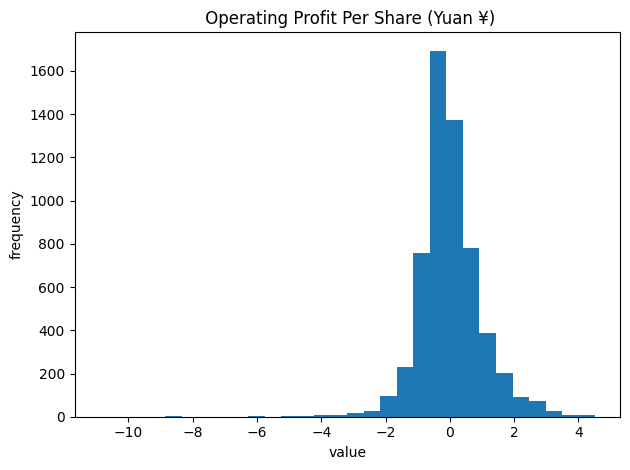

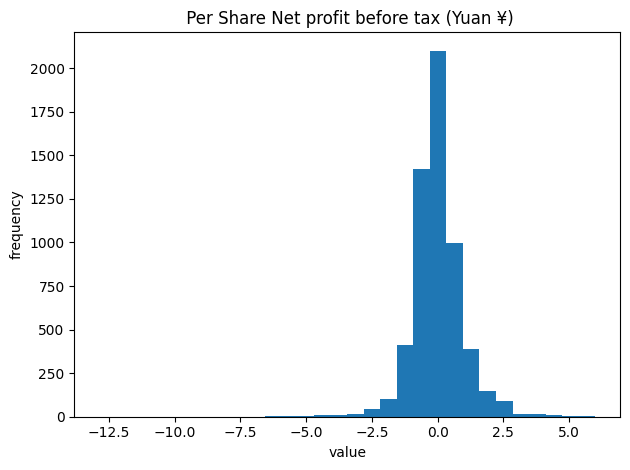

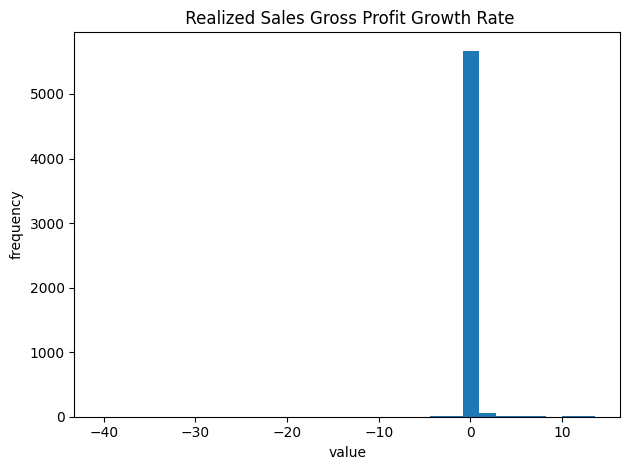

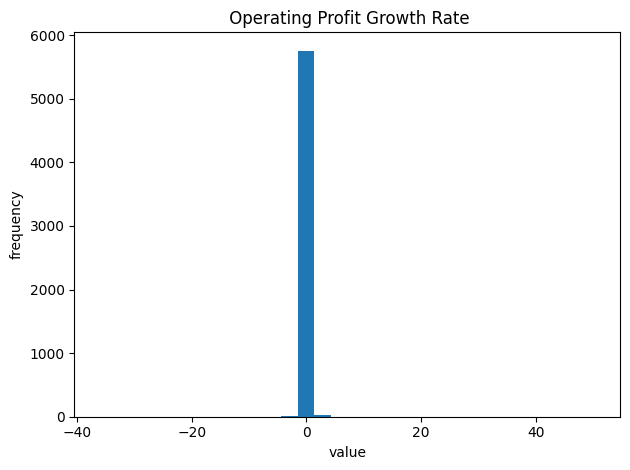

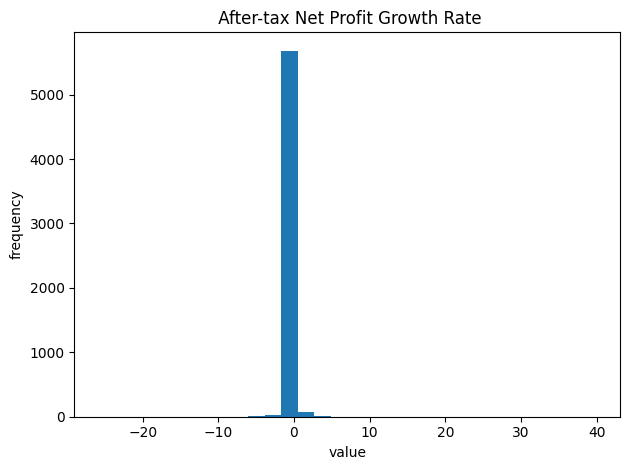

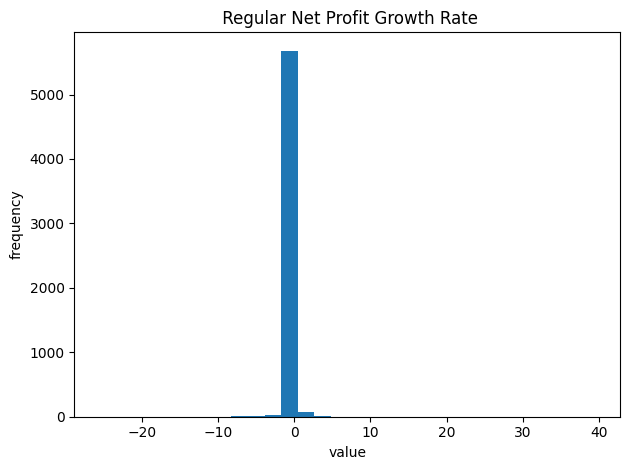

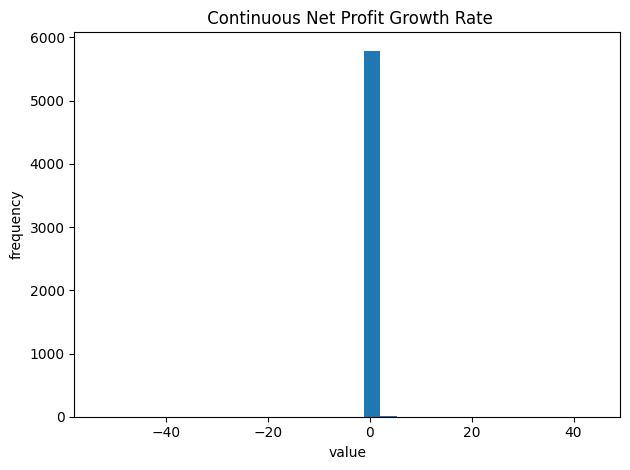

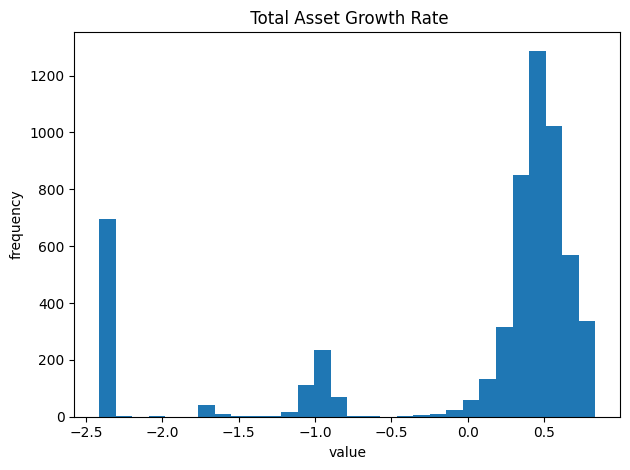

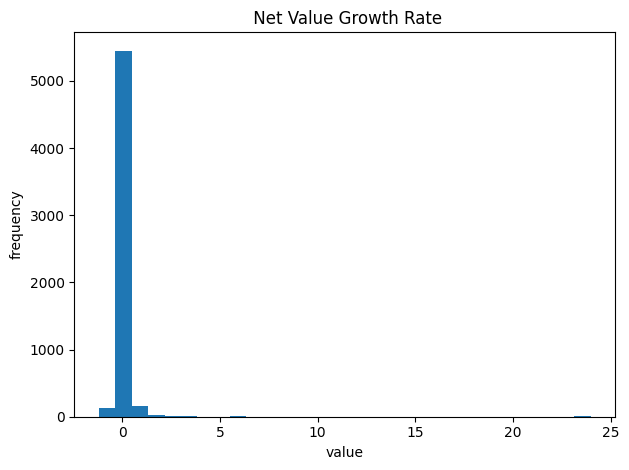

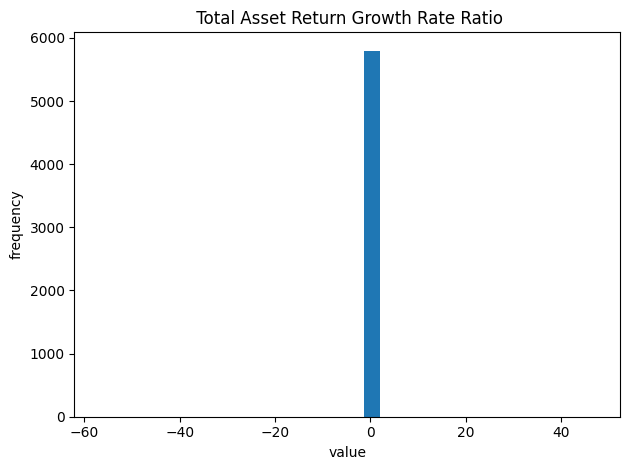

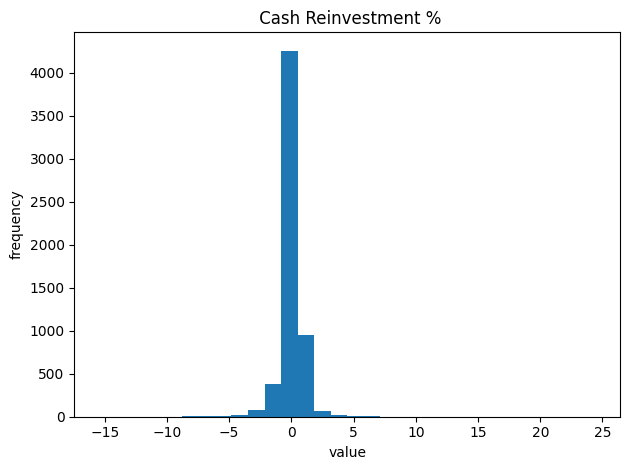

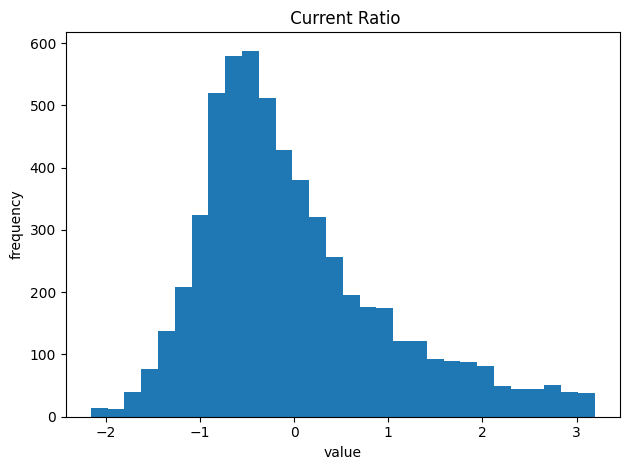

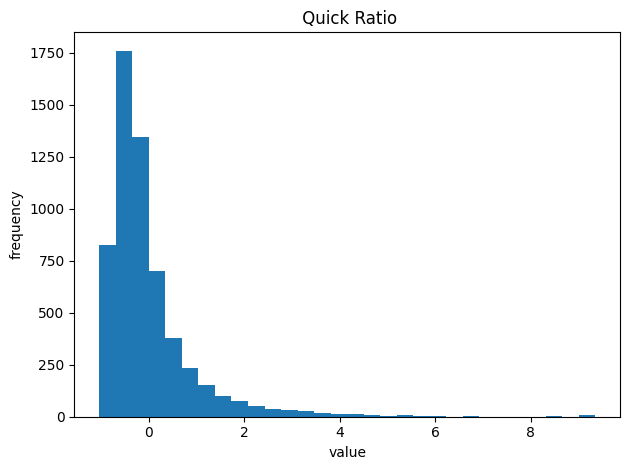

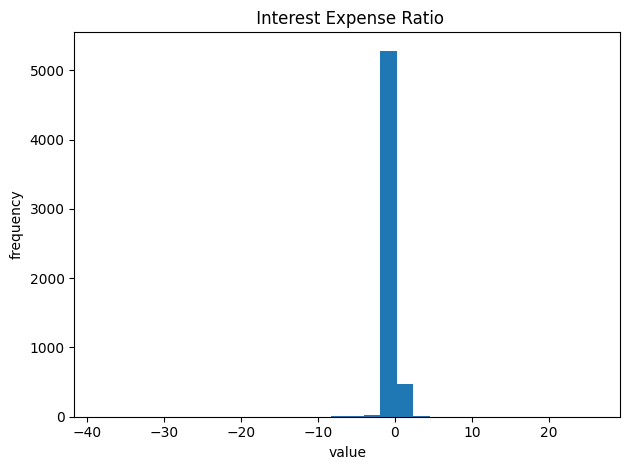

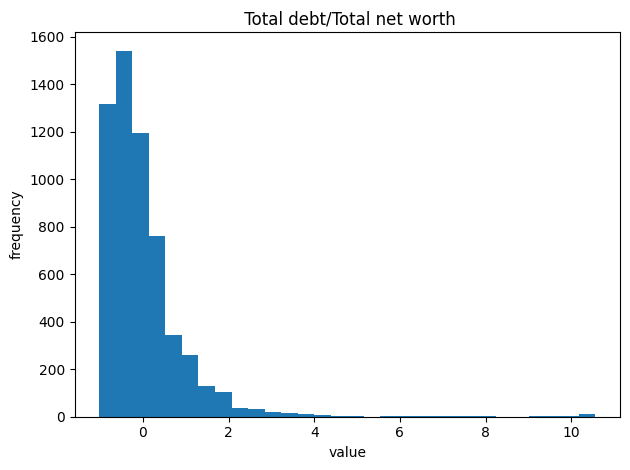

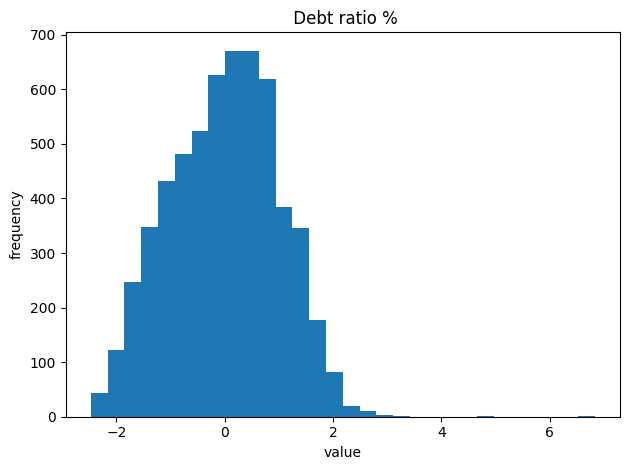

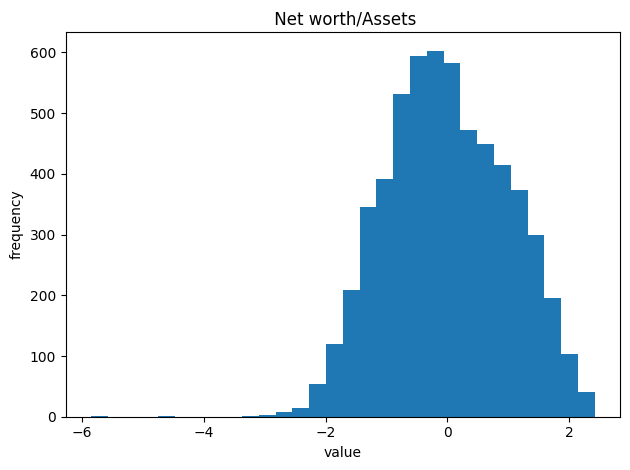

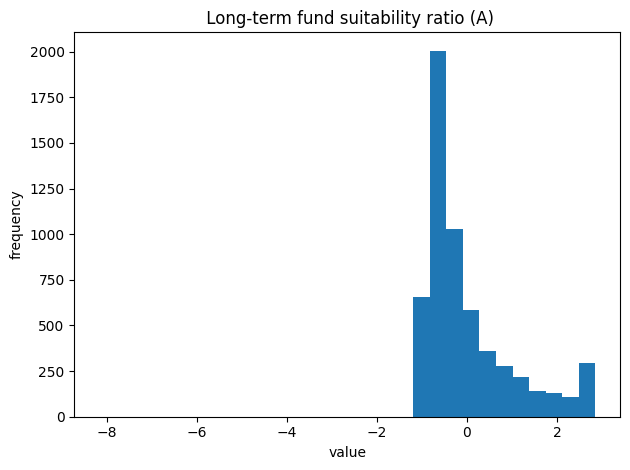

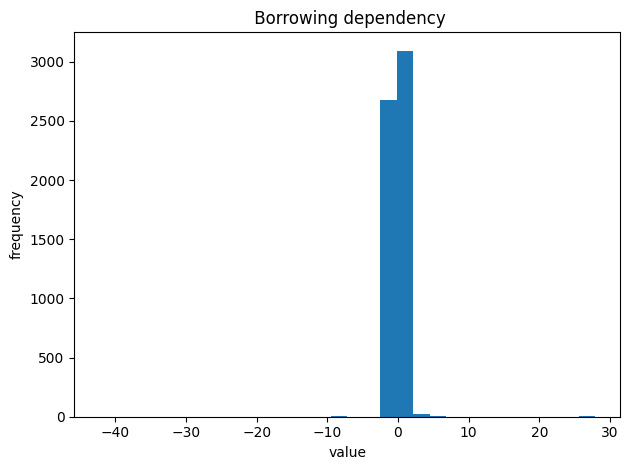

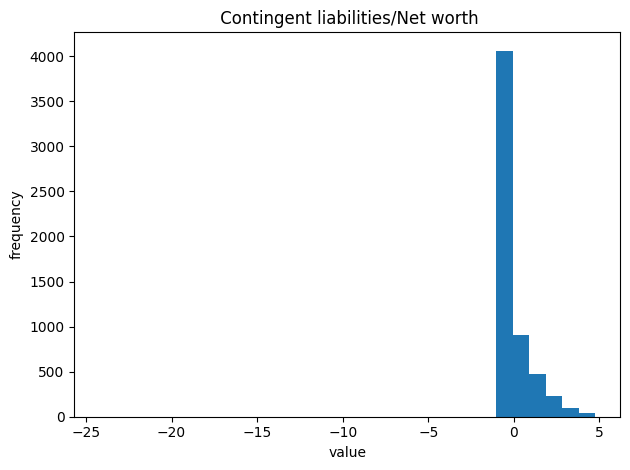

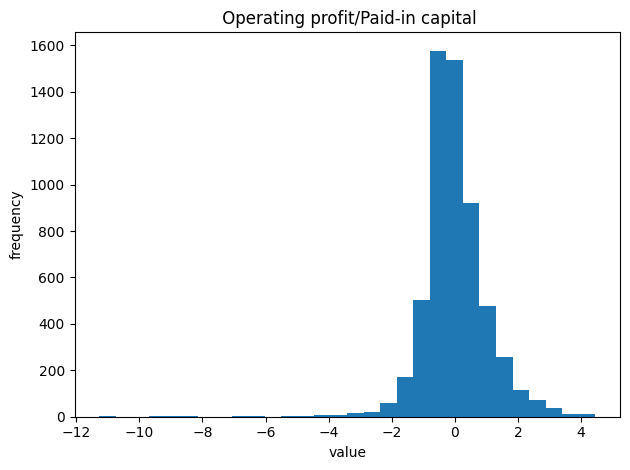

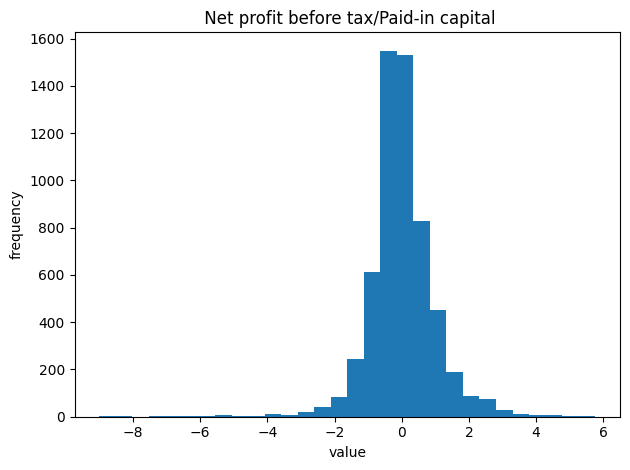

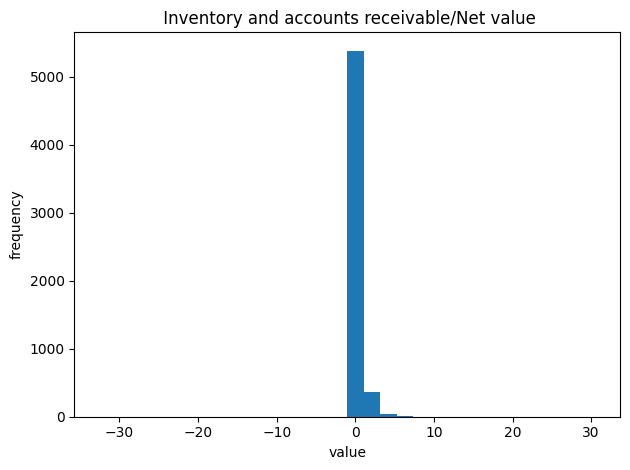

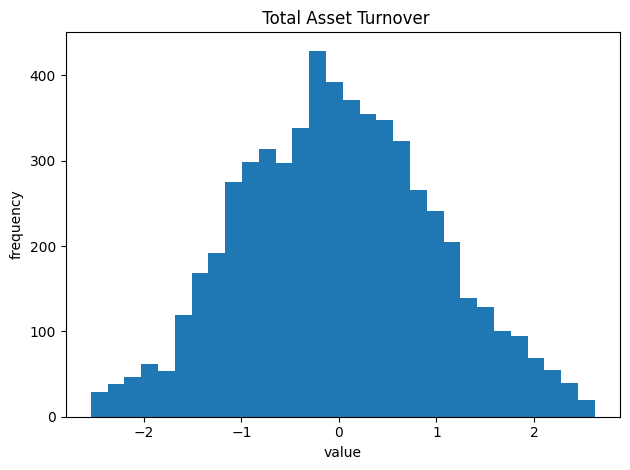

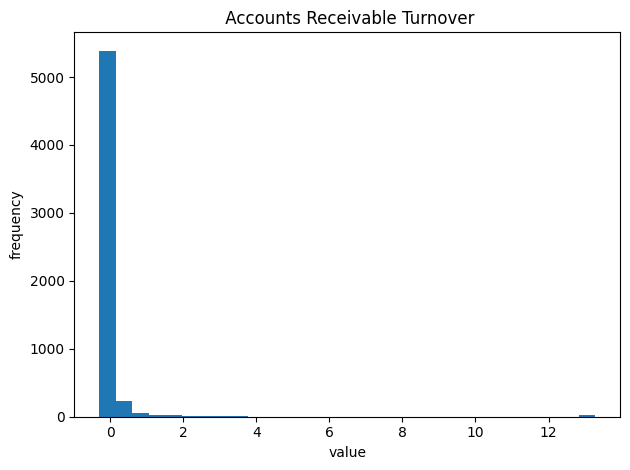

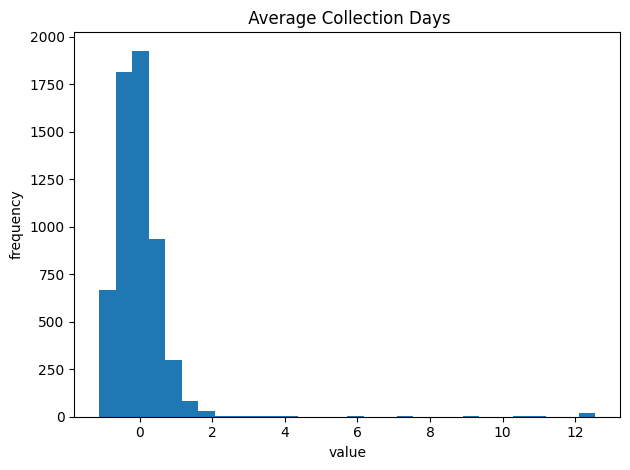

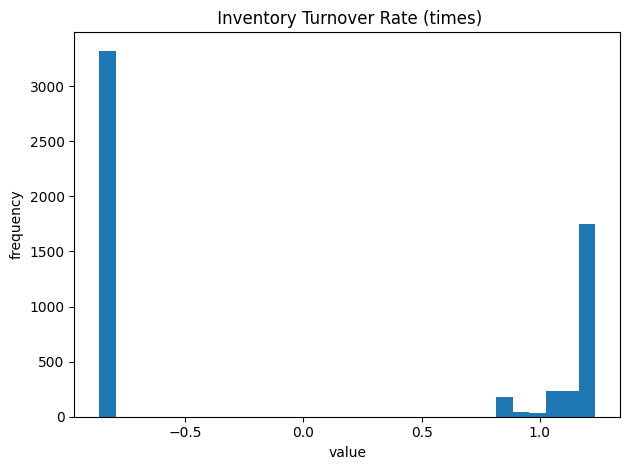

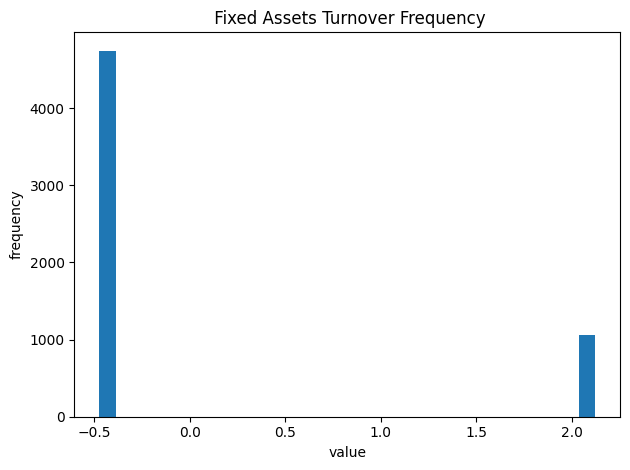

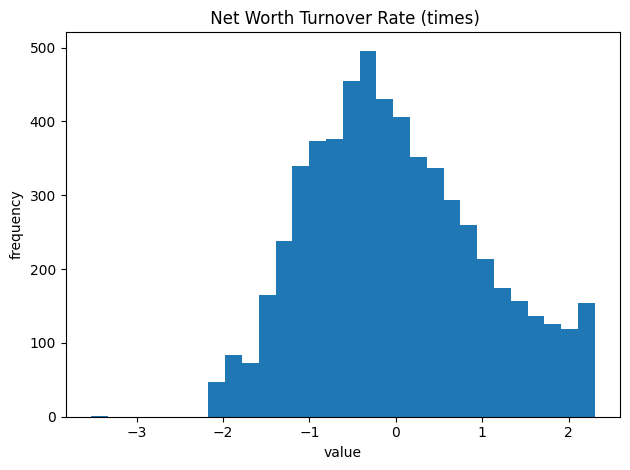

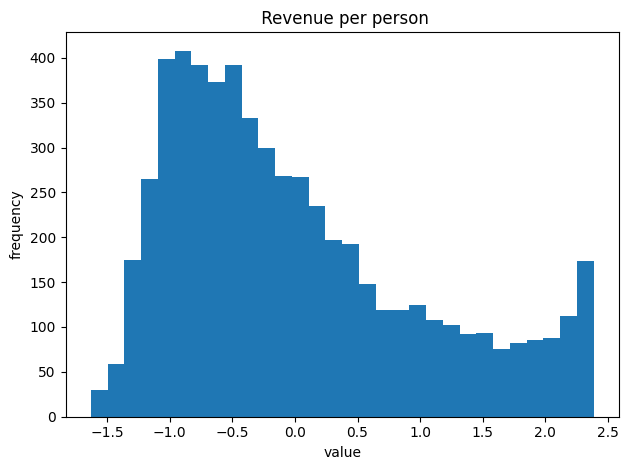

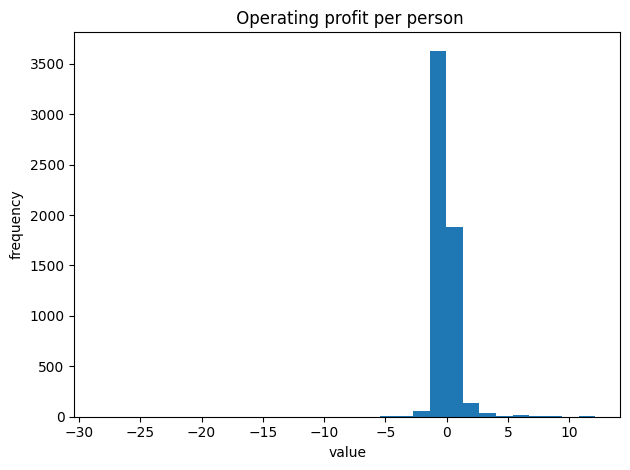

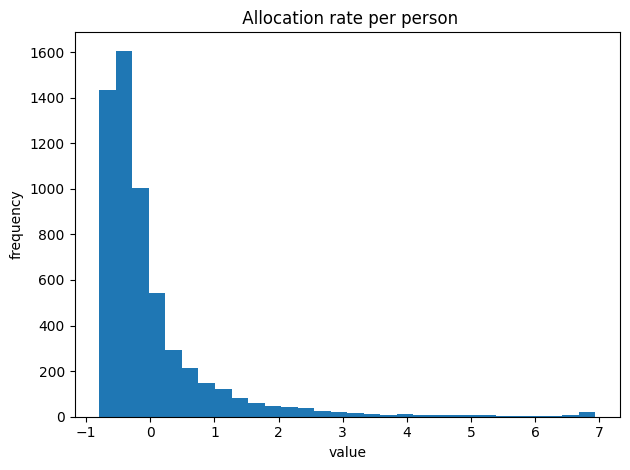

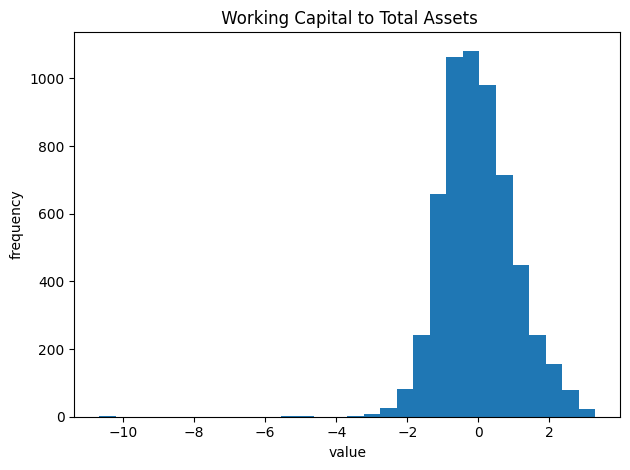

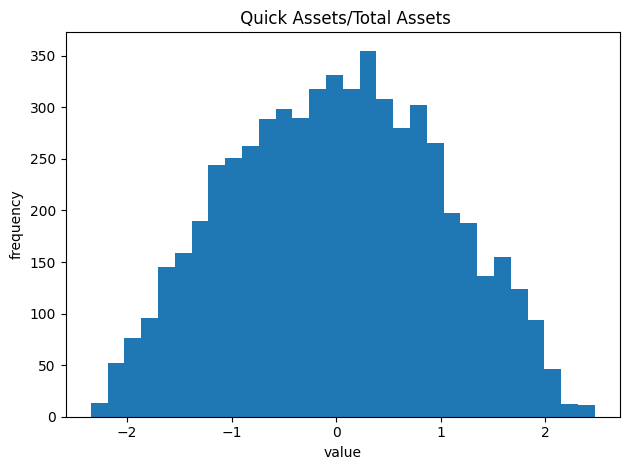

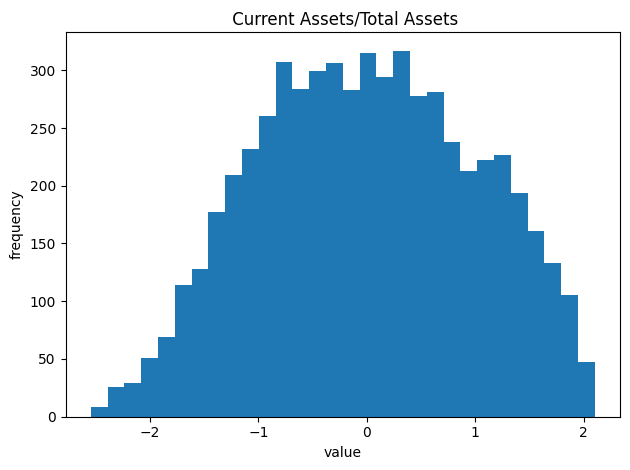

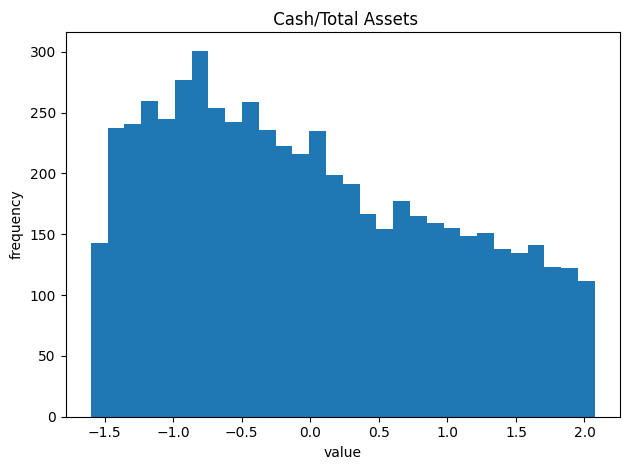

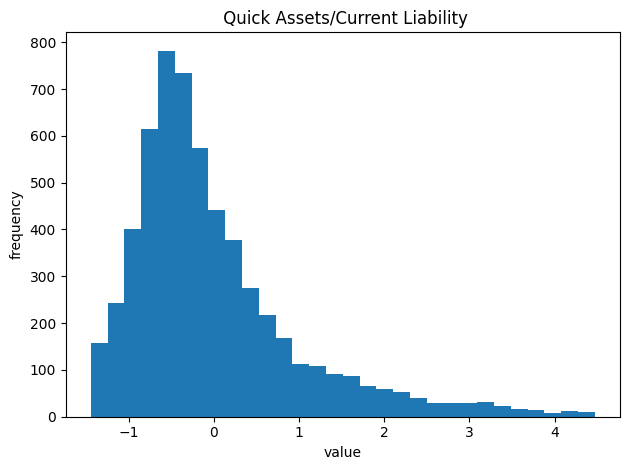

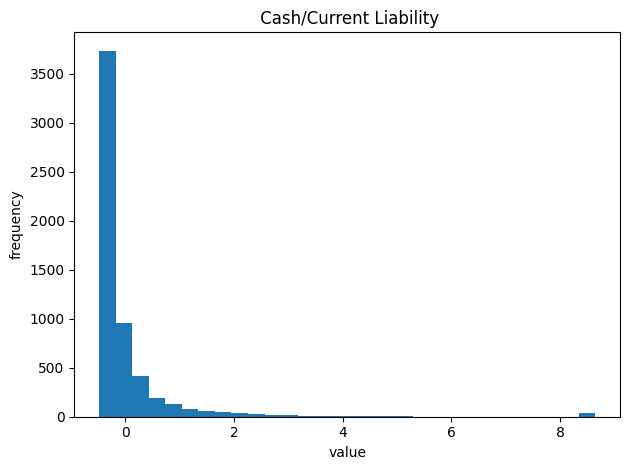

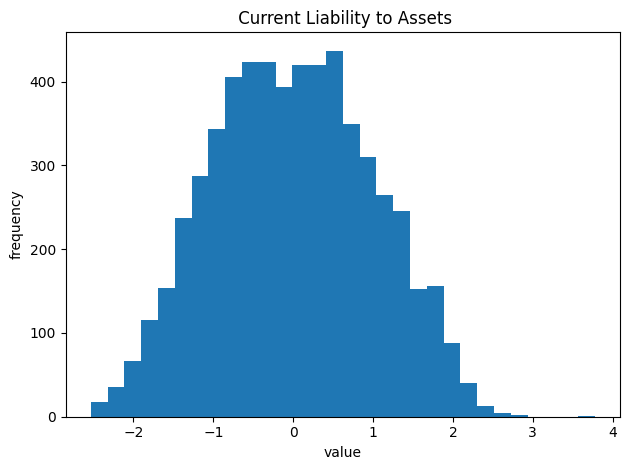

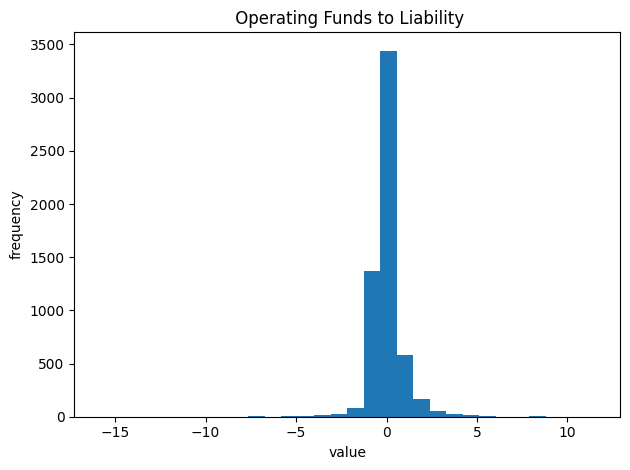

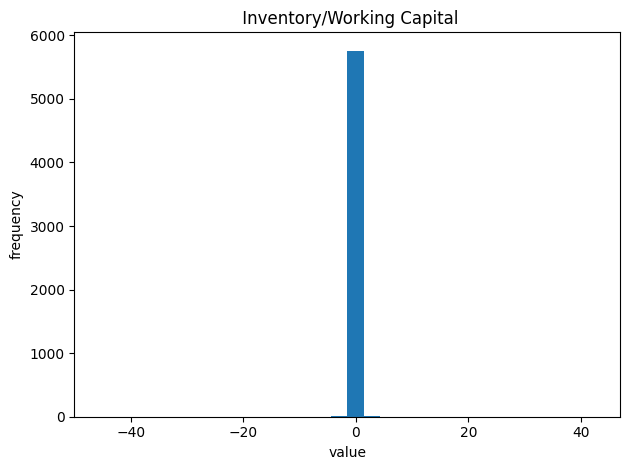

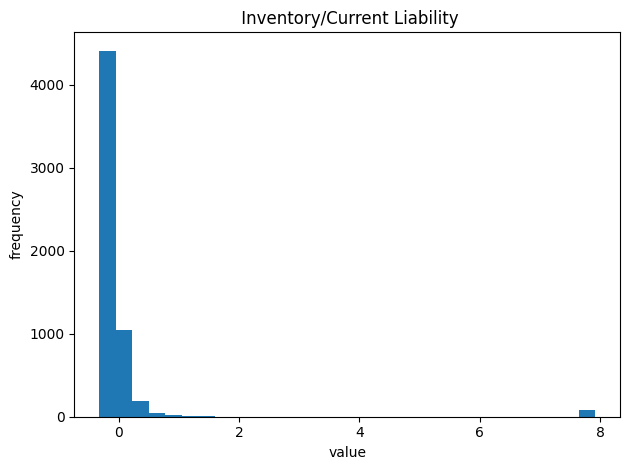

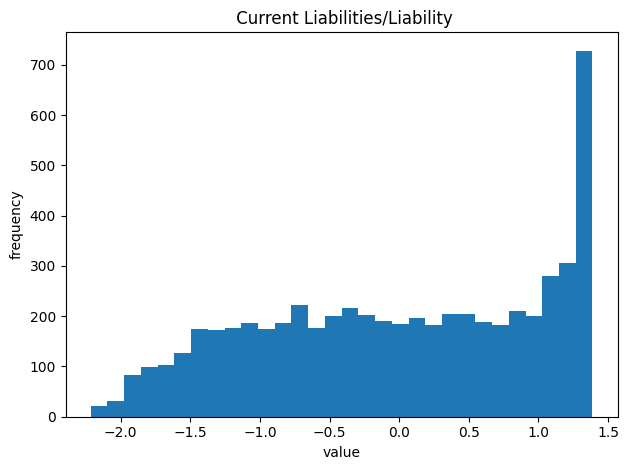

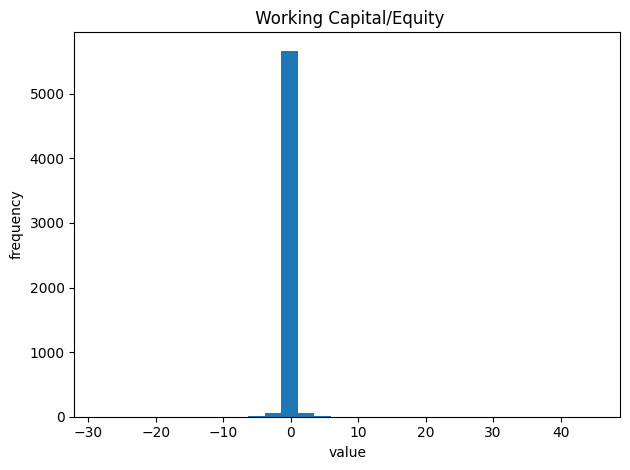

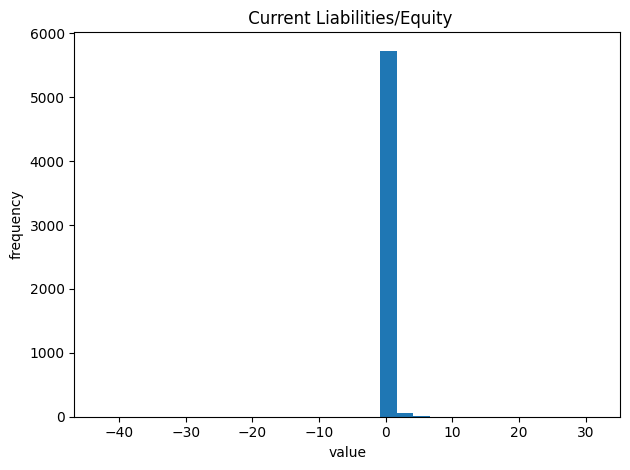

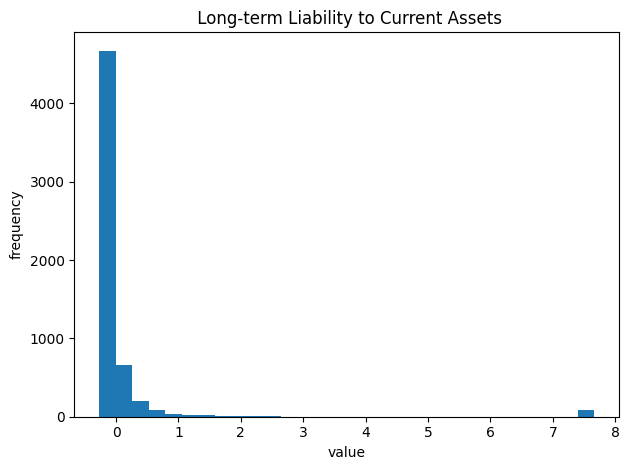

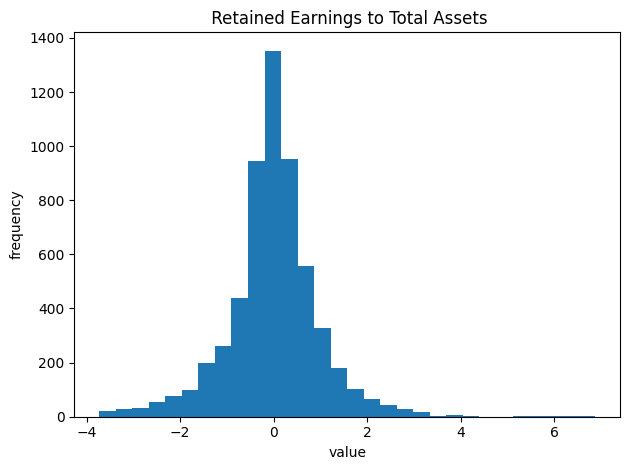

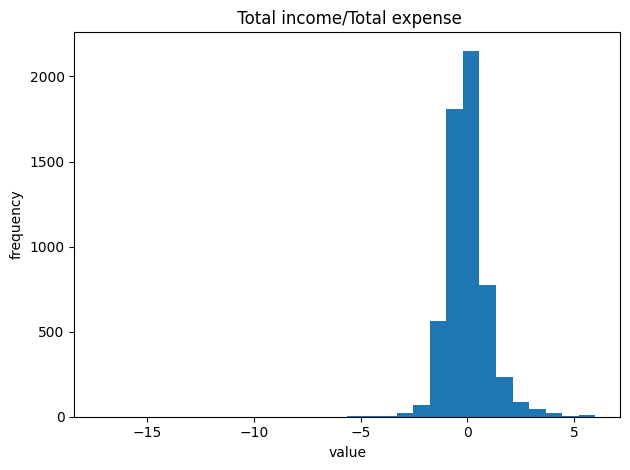

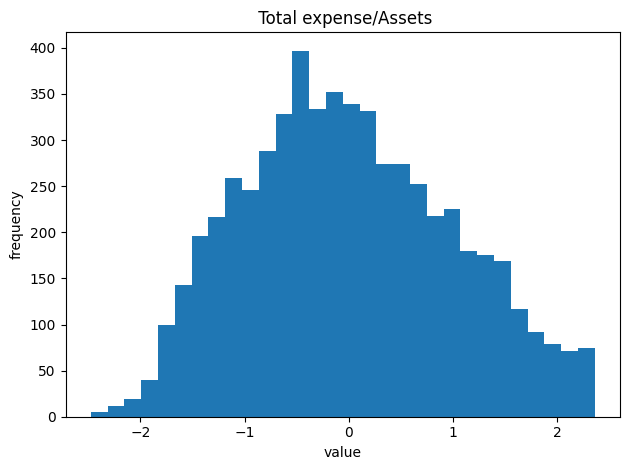

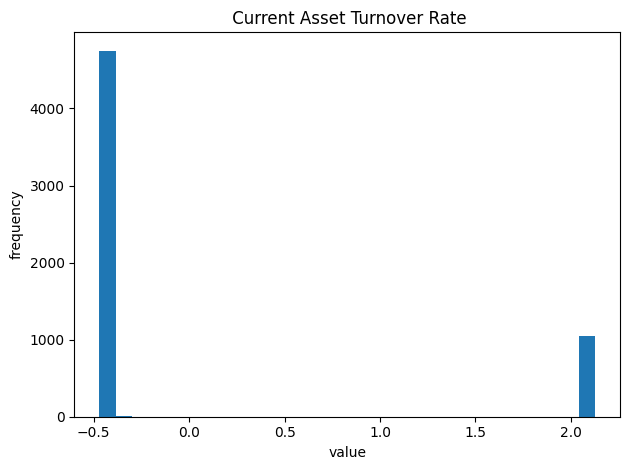

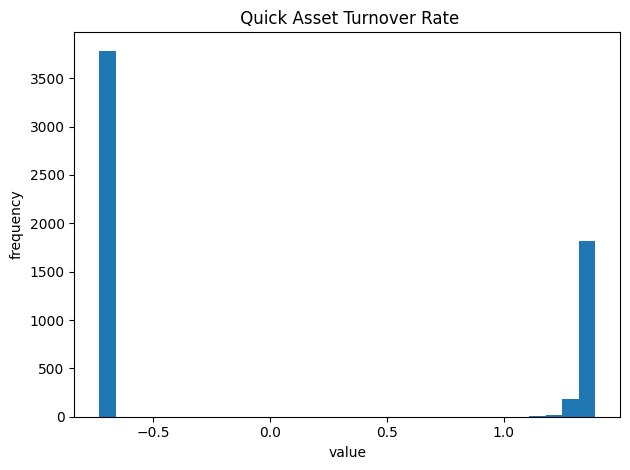

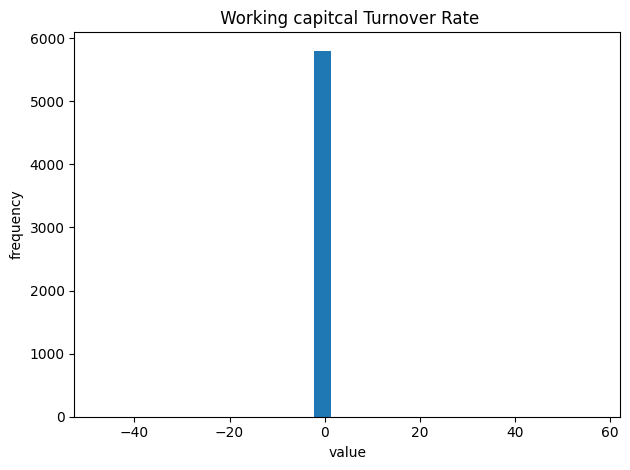

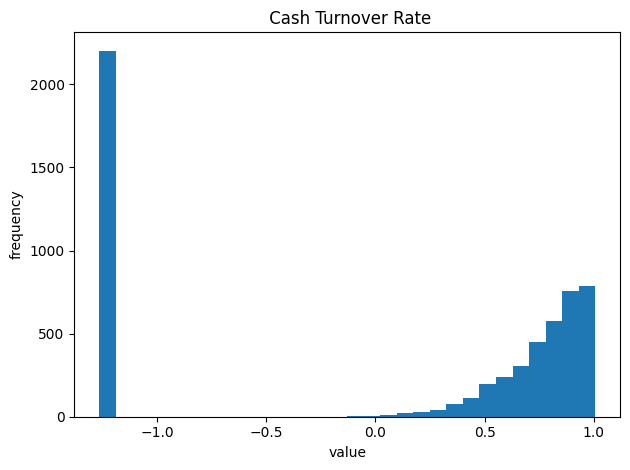

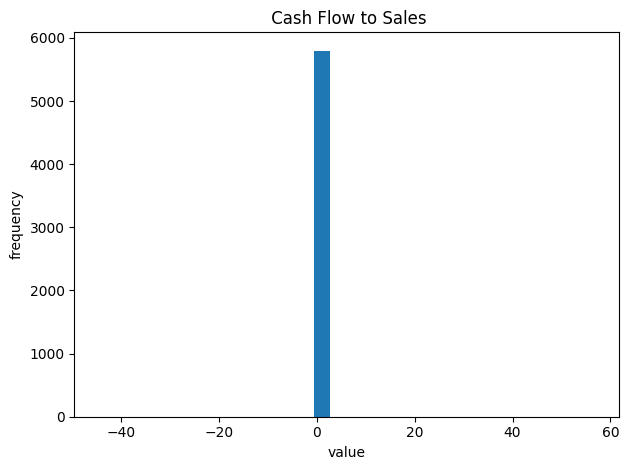

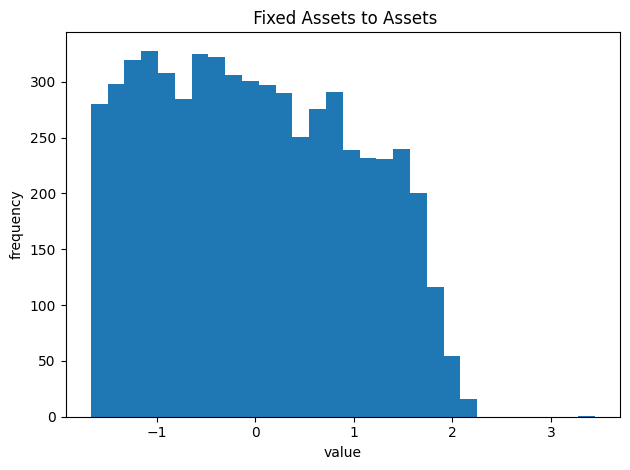

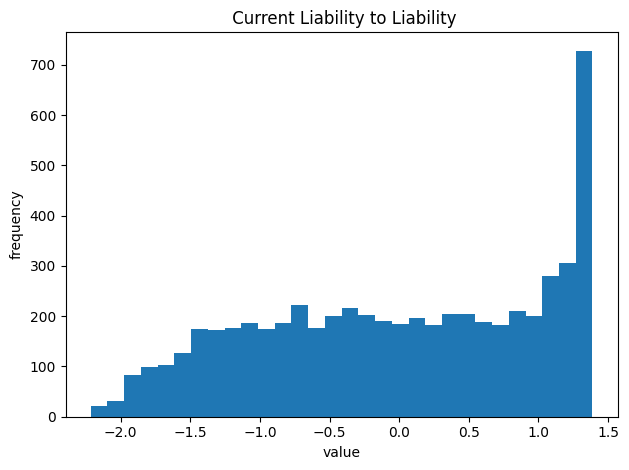

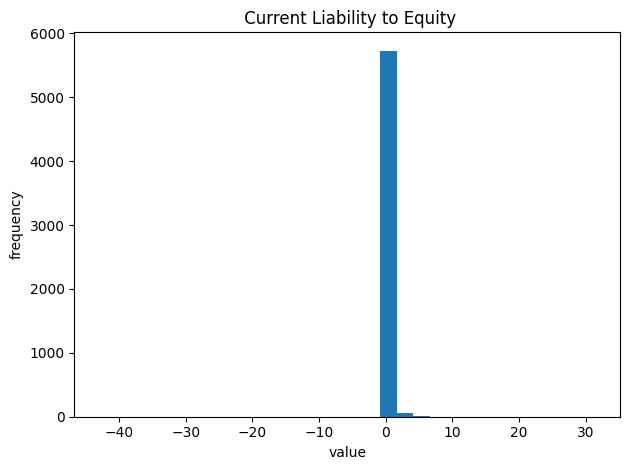

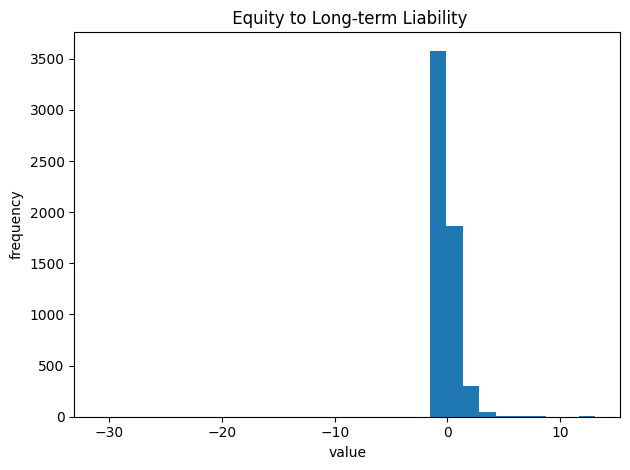

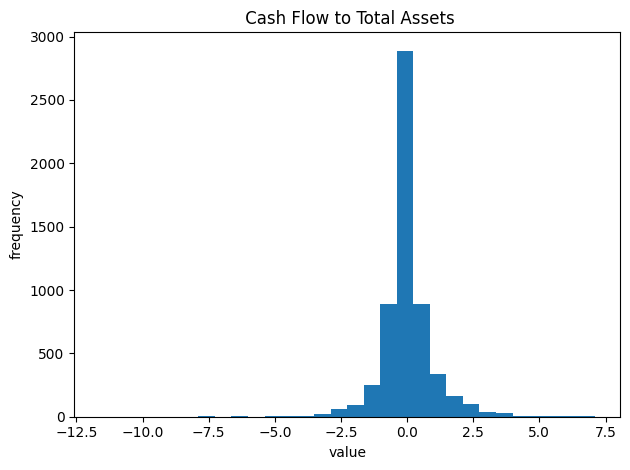

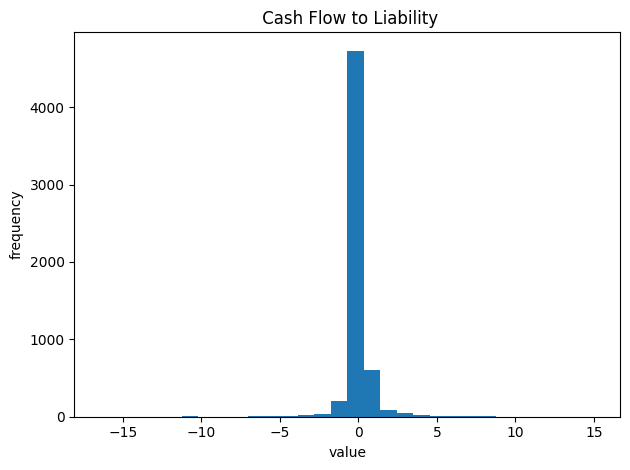

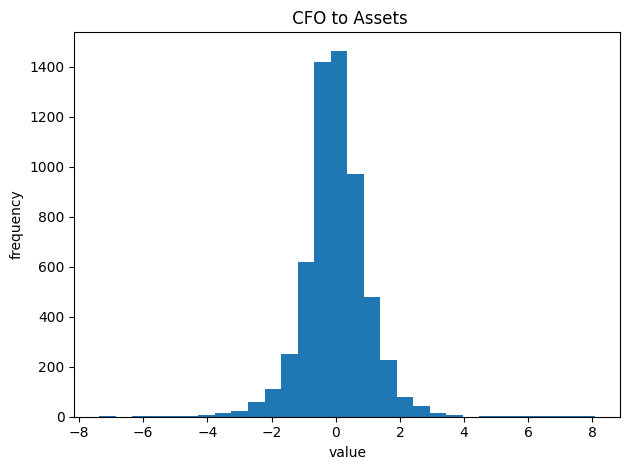

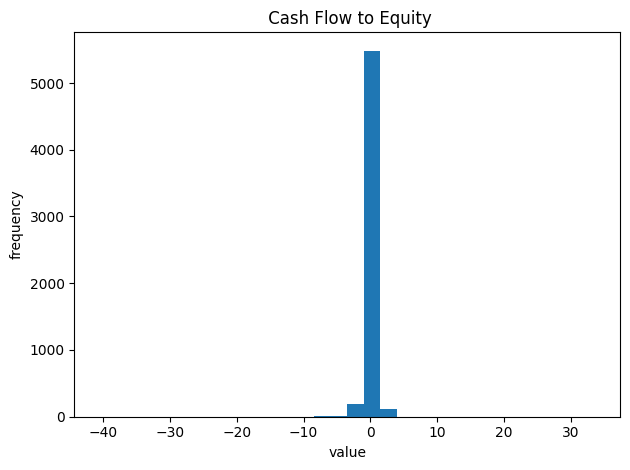

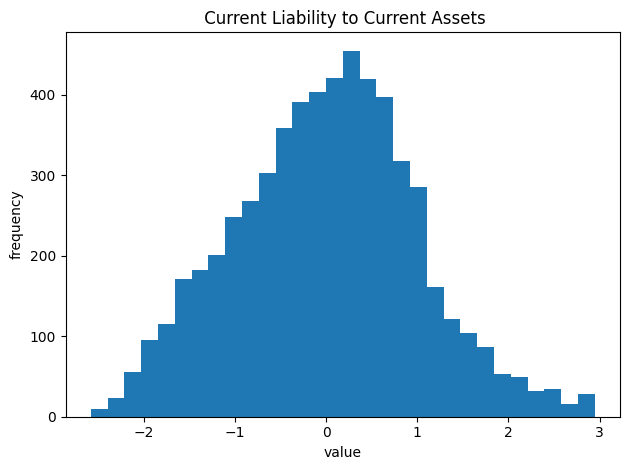

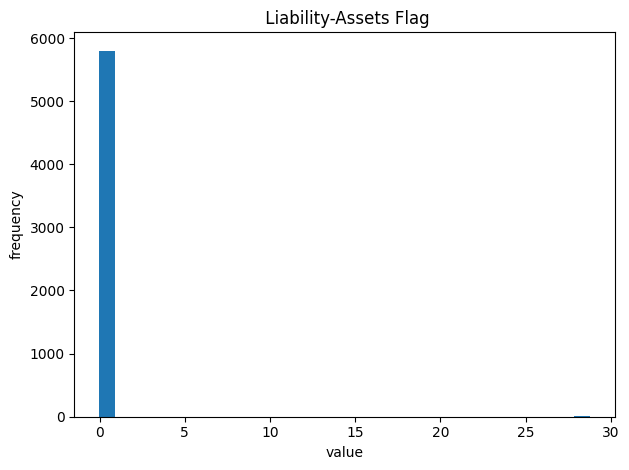

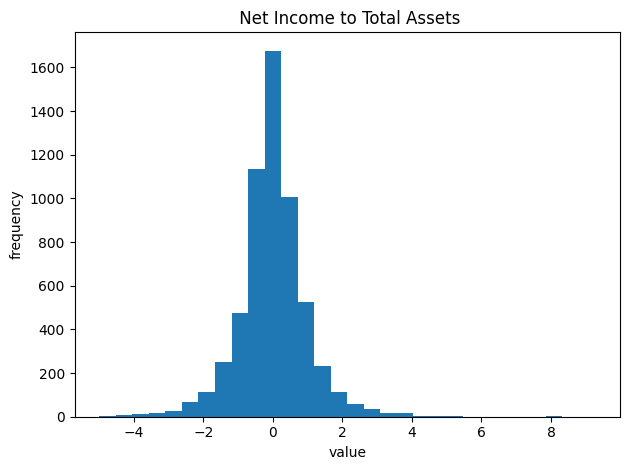

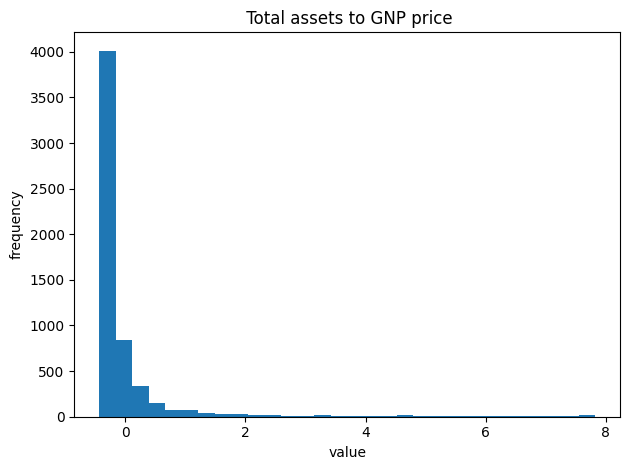

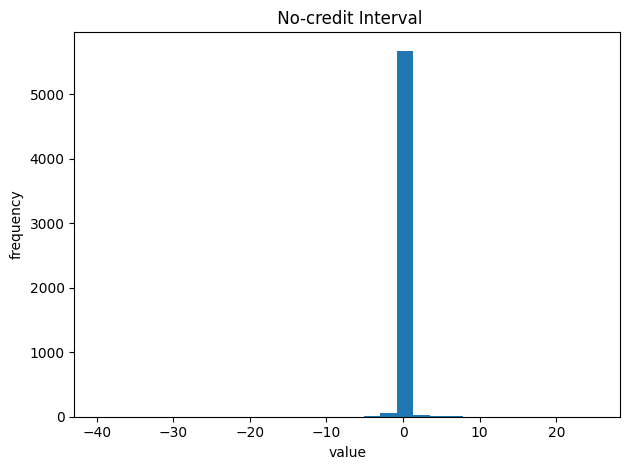

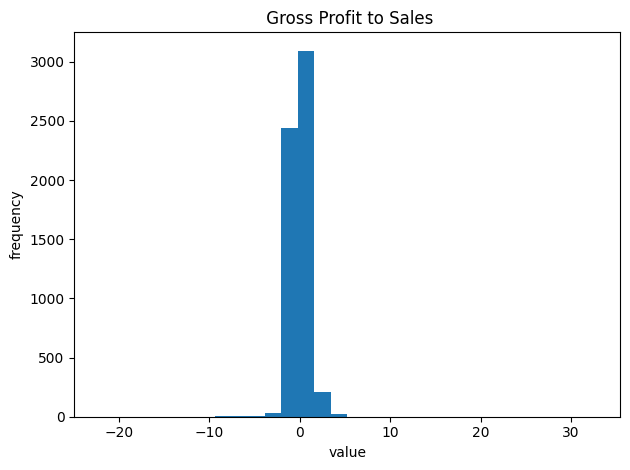

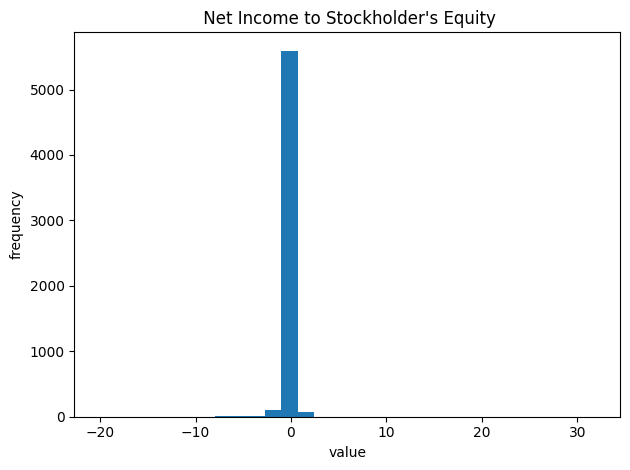

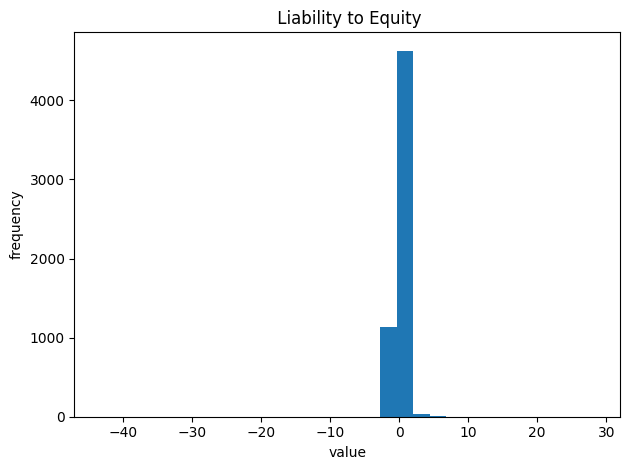

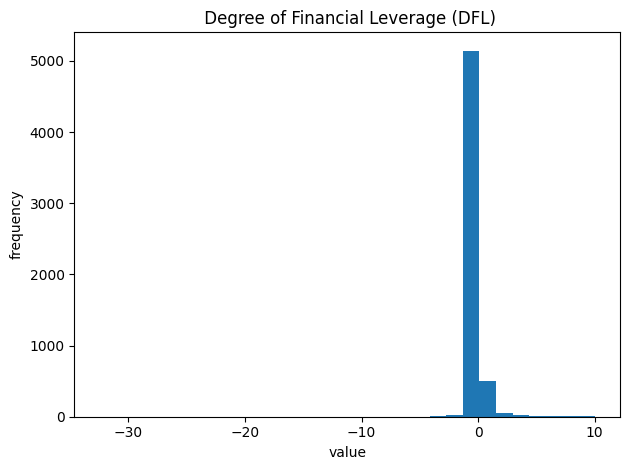

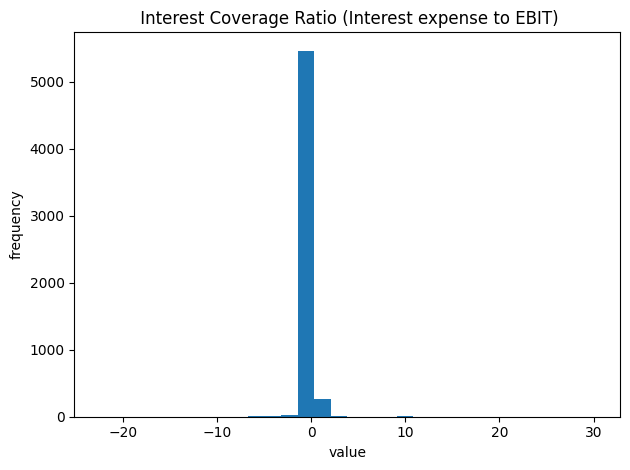

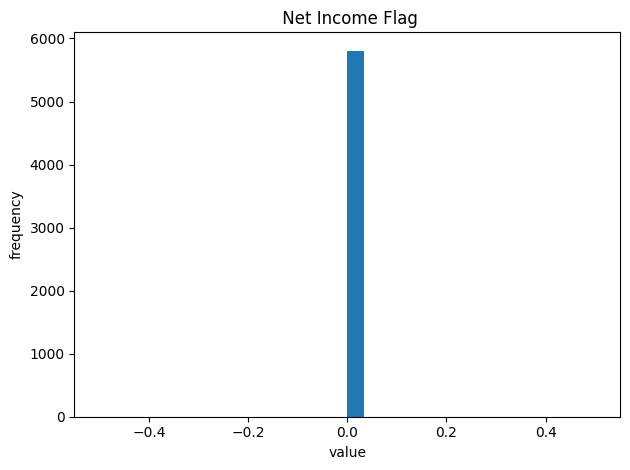

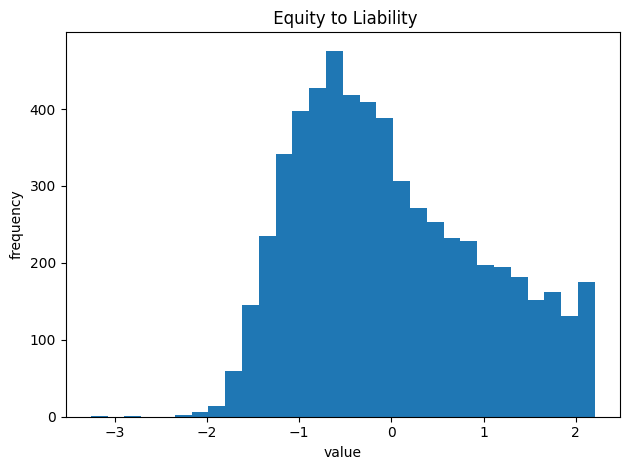

In [5]:
# Plot distributions of features after applying Yeo-Johnson transformation

for col in X_gauss.columns:
    plt.figure()                           
    plt.hist(X_gauss[col], bins=30)       
    plt.title(col)
    plt.xlabel('value');  plt.ylabel('frequency')
    plt.tight_layout()
    plt.show()

In [6]:
kept = X_gauss.columns.tolist()
print(f"{len(kept)} features kept:\n", kept)
stats = X_gauss.agg(['mean', 'std', 'skew', 'kurt']).T.round(3)
display(stats)  

95 features kept:
 [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Operating Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Continuous Net Profit G

,mean,std,skew,kurt
ROA(C) before interest and depreciation before interest,-0.0,1.0,0.155,6.408
ROA(A) before interest and % after tax,0.0,1.0,0.298,7.635
ROA(B) before interest and depreciation after tax,0.0,1.0,0.234,6.594
Operating Gross Margin,-0.0,1.0,3.033,263.656
Realized Sales Gross Margin,-0.0,1.0,3.044,264.955
...,...,...,...,...
Liability to Equity,0.0,1.0,-6.485,831.402
Degree of Financial Leverage (DFL),0.0,1.0,-7.028,376.537
Interest Coverage Ratio (Interest expense to EBIT),-0.0,1.0,6.283,423.449
Net Income Flag,0.0,0.0,0.000,0.000


From this we can see that many of these features have really high skew and kurtosis, we will filter to identify these heavy tailed features and then winsorize them. Winsorizing allows us to replace the top/bottom 1 % with the nearest percentile value, and reduce long tails without distorting middle mass. For cases where our skew is greater than 3 and the kurtosis is greater than 30 even after applying the Box-Cox normalization transform, we will apply this technique to further normalize the distribution of these heavy tailed features.

In [7]:
# Identify Heavy-Tailed Features and Winsorize
stats = X_gauss.agg(['mean', 'std', 'skew', 'kurt']).T
heavy_skew = stats.index[stats['skew'].abs() > 3]
heavy_kurt = stats.index[stats['kurt'].abs() > 30]
heavy_features = sorted(set(heavy_skew) | set(heavy_kurt))
print(f"Found {len(heavy_features)} heavy-tailed features.\n")

def winsorize_series(s, p=0.01):
    return pd.Series(st.mstats.winsorize(s, limits=[p, p]), index=s.index)

X_wins = X_gauss.copy()
for col in heavy_features:
    X_wins[col] = winsorize_series(X_wins[col])
print("Winsorization completed.\n")


Found 49 heavy-tailed features.

Winsorization completed.



In [8]:
# Remove Highly Correlated Features
def corr_filter(df, threshold=0.6):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)

X_uncorr = corr_filter(X_wins)


In [9]:
# Drop constant column manually if present
if 'Net Income Flag' in X_uncorr.columns:
    X_uncorr.drop(columns=['Net Income Flag'], inplace=True)
print(f"Number of features after cleaning: {len(X_uncorr.columns)}\n")
selector = VarianceThreshold()
selector.fit(X_uncorr)
feature_variances = pd.Series(selector.variances_, index=X_uncorr.columns)
selected_features = feature_variances.sort_values(ascending=False).head(28).index.tolist()
X_final = X_uncorr[selected_features]

print(f"Number of features after final selection: {len(X_final.columns)}\n")


Number of features after cleaning: 38

Number of features after final selection: 28



In [10]:
print("Selected 28 feature names:")
for feature in selected_features:
    print(f"'{feature}',")


Selected 28 feature names:
' ROA(C) before interest and depreciation before interest',
' Long-term Liability to Current Assets',
' Current Ratio',
' Inventory/Current Liability',
' Total expense/Assets',
' Operating Expense Rate',
' Long-term fund suitability ratio (A)',
' Current Asset Turnover Rate',
' Tax rate (A)',
' Revenue Per Share (Yuan ¥)',
' Inventory Turnover Rate (times)',
' Research and development expense rate',
' Current Liabilities/Liability',
' Total Asset Growth Rate',
' Fixed Assets Turnover Frequency',
' Revenue per person',
' Interest-bearing debt interest rate',
' Allocation rate per person',
' Total assets to GNP price',
' Contingent liabilities/Net worth',
' Total debt/Total net worth',
' Operating Gross Margin',
' Cash flow rate',
' Average Collection Days',
' Degree of Financial Leverage (DFL)',
' Accounts Receivable Turnover',
' Net Value Growth Rate',
' Realized Sales Gross Profit Growth Rate',


Plotting feature importances...


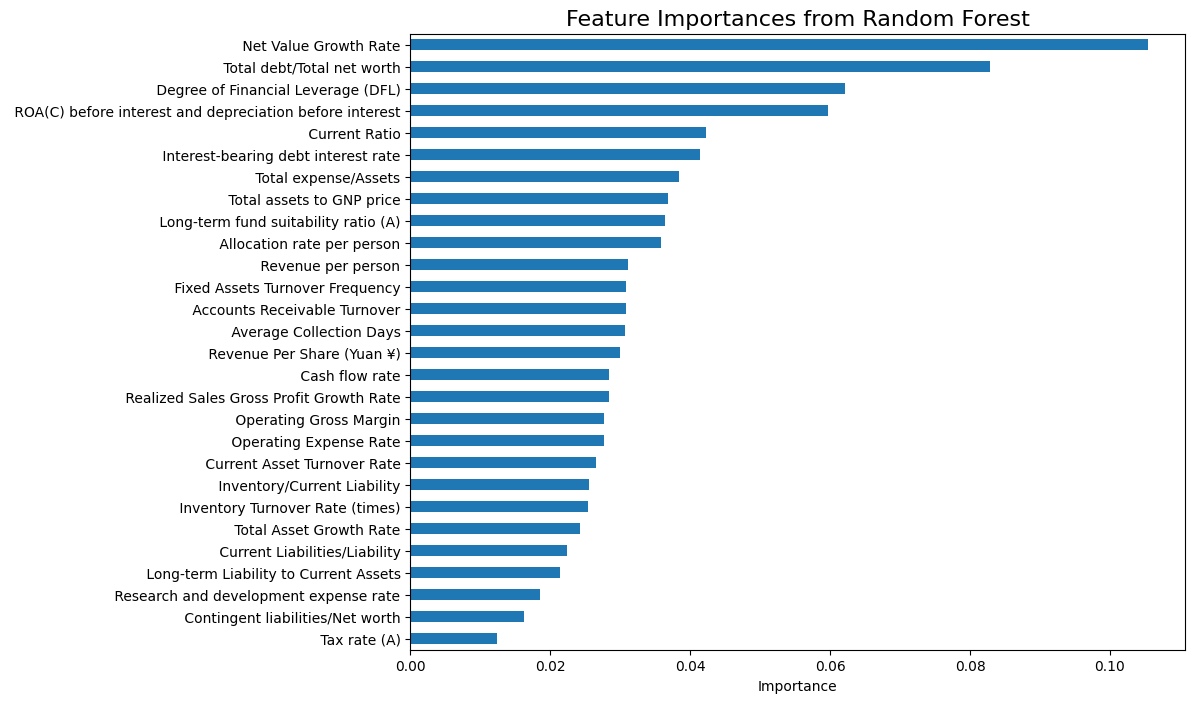

In [11]:
# Feature Importance Visualization
print("Plotting feature importances...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_final, y)
importances = pd.Series(rf.feature_importances_, index=X_final.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
importances.plot(kind='barh')
plt.title('Feature Importances from Random Forest', fontsize=16)
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()


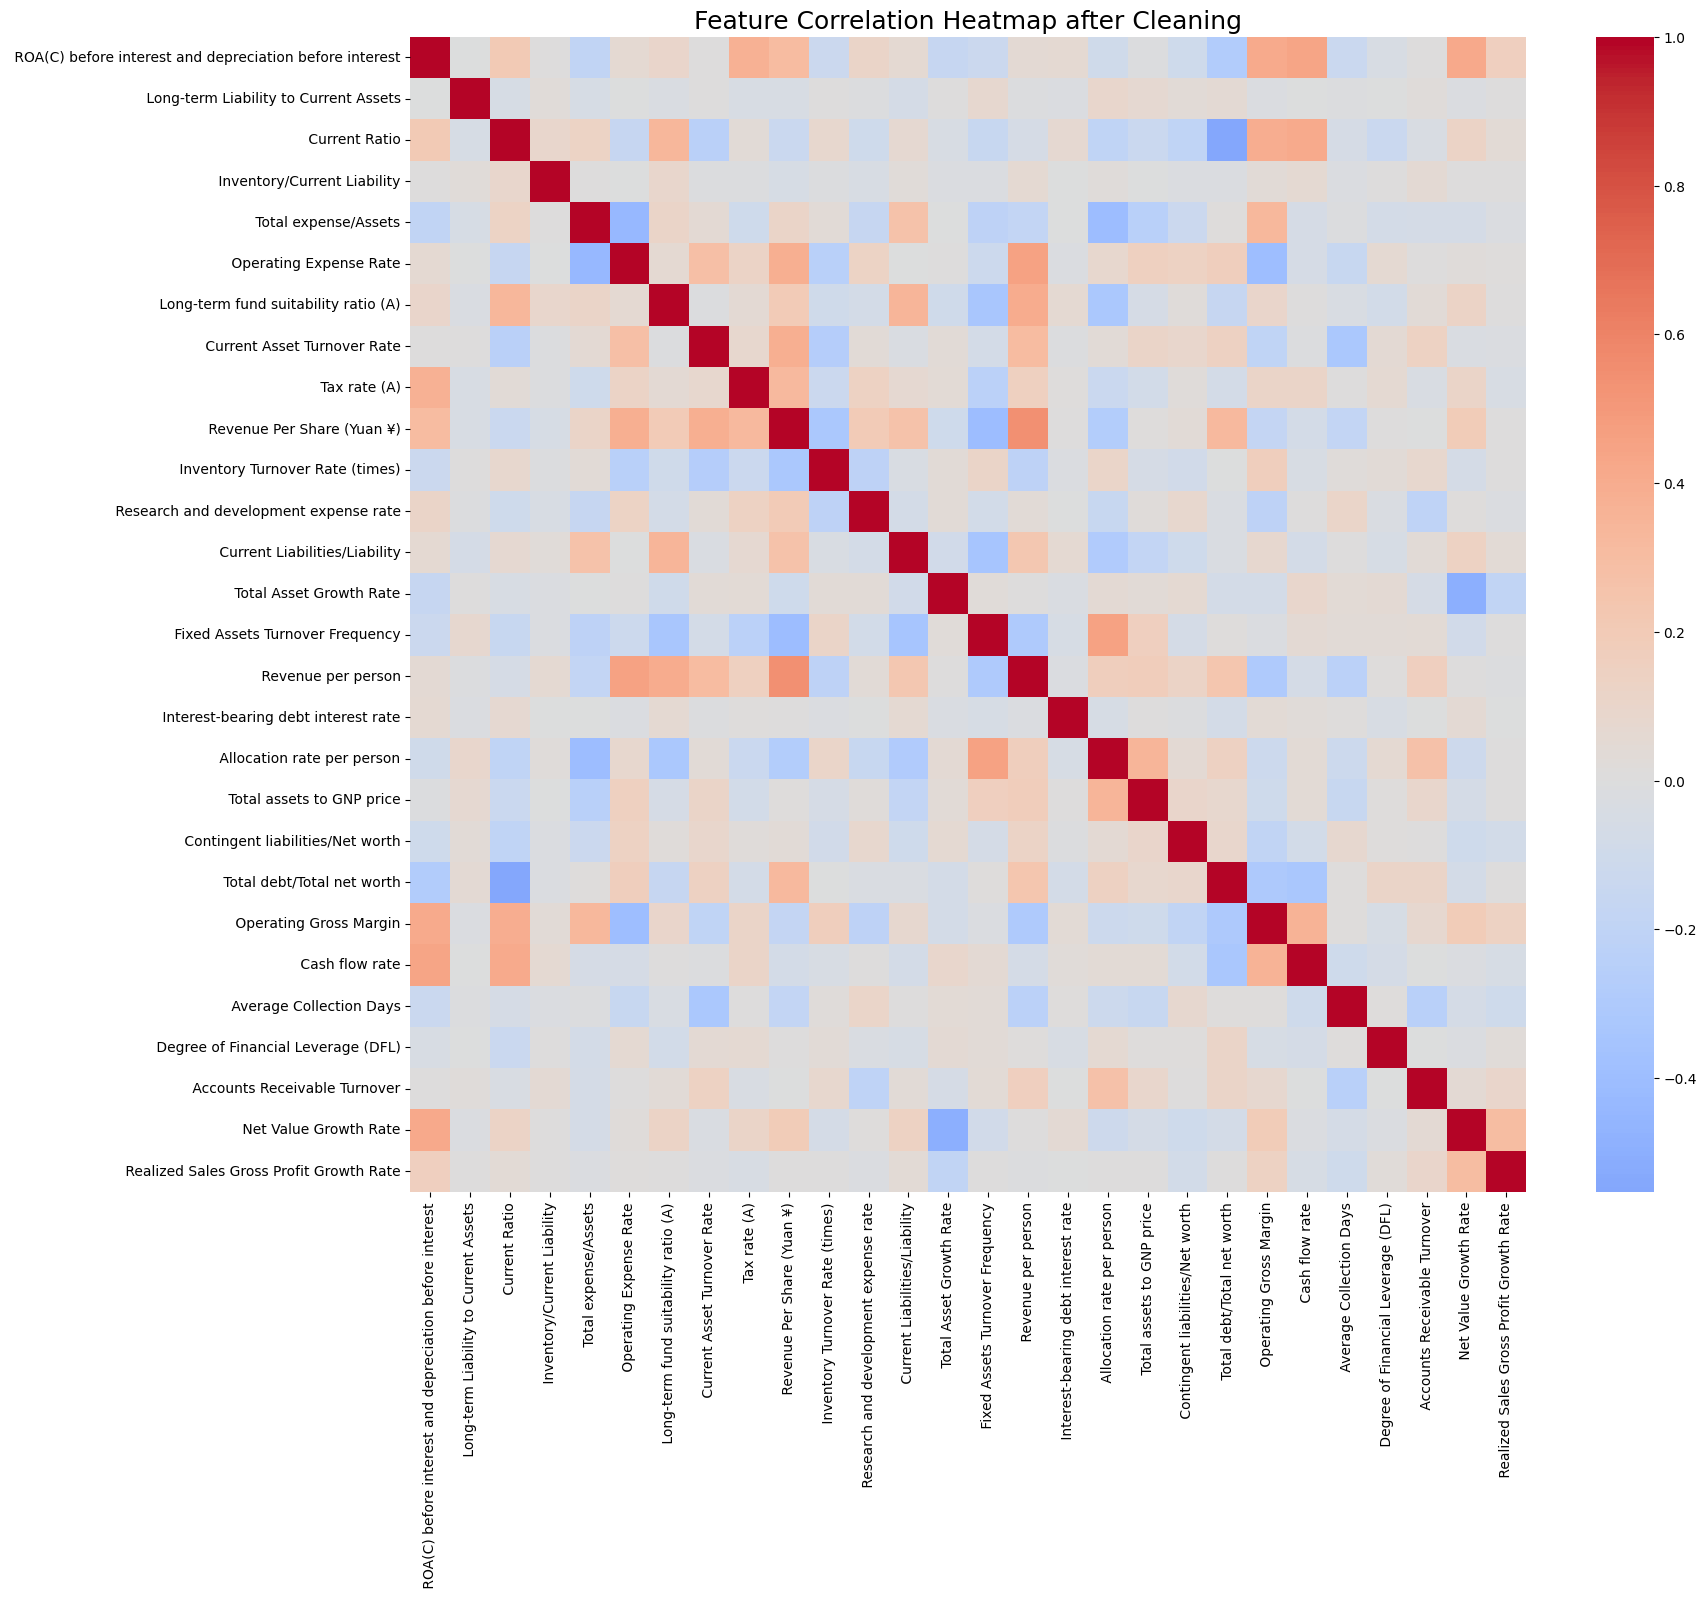

In [12]:
# Correlation heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(X_final.corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap after Cleaning', fontsize=18)
plt.show()



With our new train data (X_uncorr) we have 29 features. We will now cluster the train data into k groups, starting with k=4 and iterating to k=8 until we are able to garuntee that there is at least one bankrupted company in each cluster. To do this, we will use the unsupervised learning technique KMeans Clustering. Below, we are able to cluster into 4 groups with each group having at least one bankrupted comapny. 

In [13]:
# KMeans Clustering setup
k = 4
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_final) + 1


print("Attaching cluster labels to data...")
clustered_df = X_final.copy()
clustered_df['Cluster'] = labels
clustered_df['Bankrupt?'] = y
clustered_df['Index'] = idx_col
print("KMeans clustering completed.\n")

# Table to show cluster composition
cluster_df = pd.DataFrame({
    "cluster": labels,      # labels returned by km.fit_predict
    "bankrupt": y.values    # 1 = bankrupt, 0 = healthy
})

# summary table: total firms, # bankrupt, % bankrupt per cluster
summary = (
    cluster_df
    .groupby("cluster")["bankrupt"]
    .agg(total   = "count",
         bankrupt= "sum")
    .assign(pct_bankrupt = lambda t: t["bankrupt"] / t["total"])
    .sort_index()
)

print("\nCluster composition:")
display(summary)            

Attaching cluster labels to data...
KMeans clustering completed.


Cluster composition:


,total,bankrupt,pct_bankrupt
cluster,,,
1,1353,39,0.028825
2,1061,78,0.073516
3,2207,70,0.031717
4,1186,11,0.009275


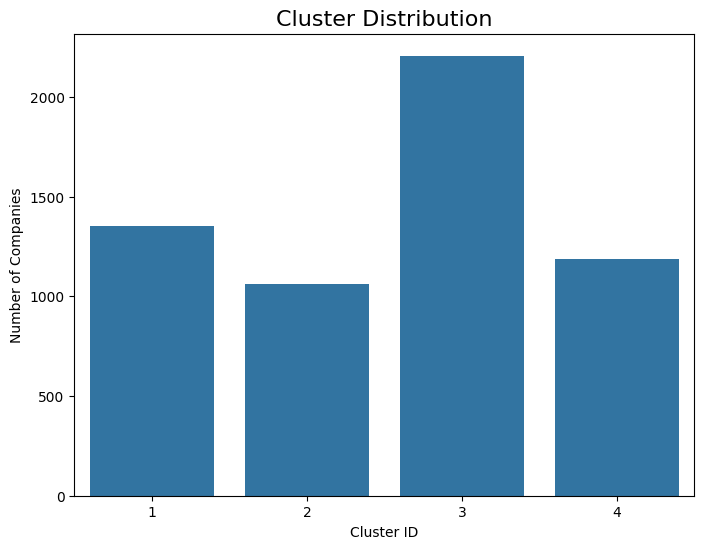

In [14]:
# Distribution of clusters
plt.figure(figsize=(8, 6))
sns.countplot(x=labels)
plt.title('Cluster Distribution', fontsize=16)
plt.xlabel('Cluster ID')
plt.ylabel('Number of Companies')
plt.show()


Above, we attached our cluster IDs, the Index column, and the Bankrupt? column back to our processed train df under the variable "clustered_df". We also plotted the number of companies in each cluster. Now, we will train a supervised classification model, random forest classifier, using this so we are able to predict the cluster classification of new test data points in our generalization file. 

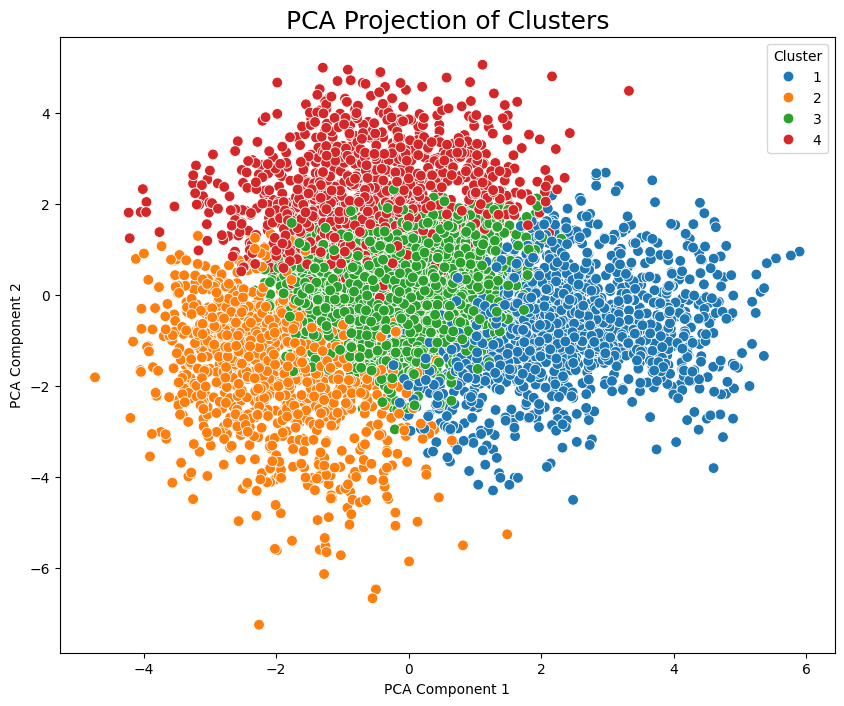

In [15]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_final)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='tab10', s=60)
plt.title('PCA Projection of Clusters', fontsize=18)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


Generating 3D PCA visualization...


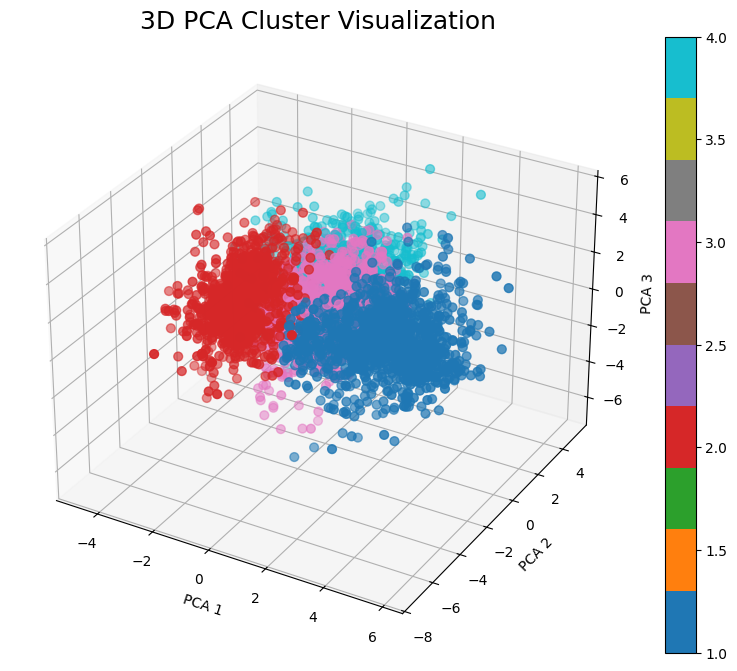

In [16]:
# PCA for 3D visualization
print("Generating 3D PCA visualization...")
pca_3d = PCA(n_components=3)
X_pca3 = pca_3d.fit_transform(X_final)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], c=labels, cmap='tab10', s=40)
ax.set_title('3D PCA Cluster Visualization', fontsize=18)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter)
plt.show()


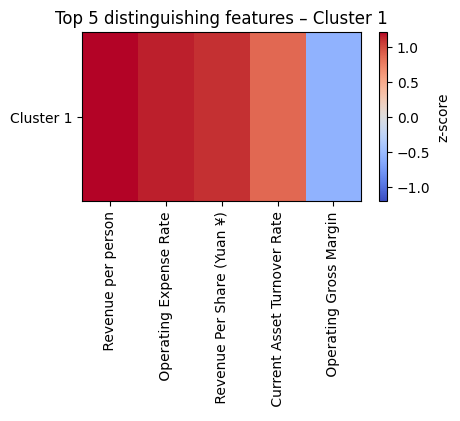

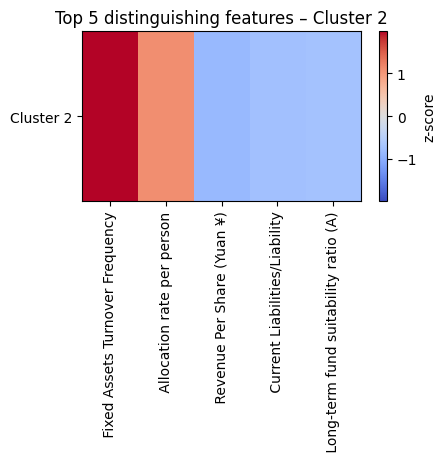

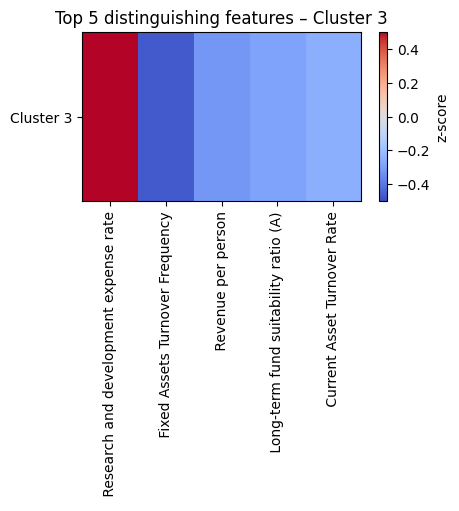

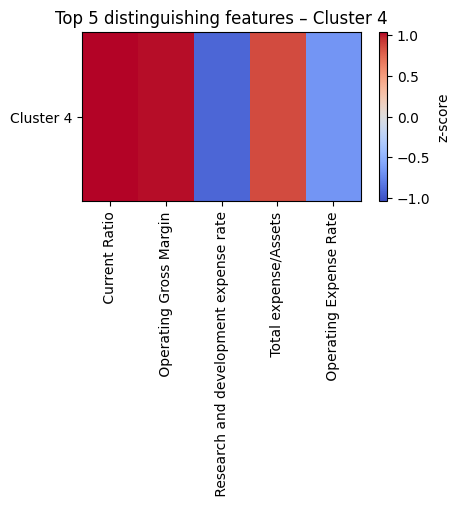

In [17]:
# Identifying useful characteristics in each subgroup:

# plot heatmap to see how important of each feature is for each cluster 
overall_mean = X_final.mean()
overall_std  = X_final.std()
z            = ((X_final - overall_mean) / overall_std).assign(cluster=labels)
cluster_z    = z.groupby('cluster').mean()

N = 5                    # how many features to show per cluster
cmap = 'coolwarm'        # diverging colour map for ±z

# heatmap for each cluster 
for cl in cluster_z.index:                 # 0,1,2,3
    # pick this cluster’s top‑N features by |z|
    top = (cluster_z.loc[cl].abs()
           .sort_values(ascending=False)
           .head(N).index)
    
    
    # build a 1×N matrix of z‑scores for imshow
    mat = cluster_z.loc[[cl], top].values
    
    plt.figure(figsize=(N*0.9, 2.2))
    plt.imshow(mat, aspect='auto', cmap=cmap,
               vmin=-np.max(np.abs(mat)), vmax=np.max(np.abs(mat)))
    
    plt.xticks(range(N), top, rotation=90, ha='center')
    plt.yticks([0], [f'Cluster {cl}'])      # label 1‑4 instead of 0‑3
    plt.colorbar(label='z‑score')
    plt.title(f'Top {N} distinguishing features – Cluster {cl}')
    plt.tight_layout()
    plt.show()


Index([' ROA(C) before interest and depreciation before interest',
       ' Long-term Liability to Current Assets', ' Current Ratio',
       ' Inventory/Current Liability', ' Total expense/Assets',
       ' Operating Expense Rate', ' Long-term fund suitability ratio (A)',
       ' Current Asset Turnover Rate', ' Tax rate (A)',
       ' Revenue Per Share (Yuan ¥)', ' Inventory Turnover Rate (times)',
       ' Research and development expense rate',
       ' Current Liabilities/Liability', ' Total Asset Growth Rate',
       ' Fixed Assets Turnover Frequency', ' Revenue per person',
       ' Interest-bearing debt interest rate', ' Allocation rate per person',
       ' Total assets to GNP price', ' Contingent liabilities/Net worth',
       ' Total debt/Total net worth', ' Operating Gross Margin',
       ' Cash flow rate', ' Average Collection Days',
       ' Degree of Financial Leverage (DFL)', ' Accounts Receivable Turnover',
       ' Net Value Growth Rate', ' Realized Sales Gross Profit 

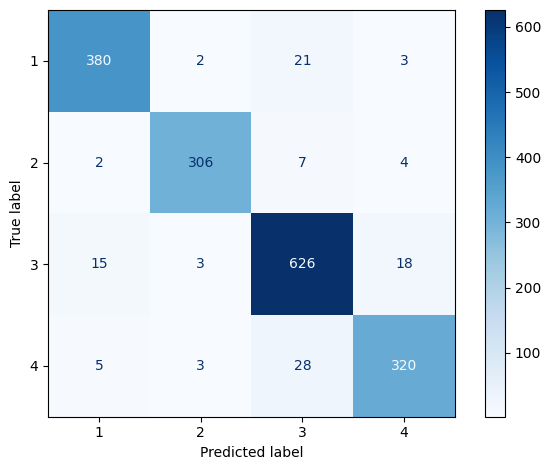

Random Forest model saved as 'cluster_classifier_rf.joblib'.



In [19]:
y_cluster = clustered_df["Cluster"].values           # 1 … 4
X_full    = clustered_df.drop(columns=["Cluster",    # prediction target
                             "Bankrupt?",  # unrelated for this task
                             "Index"])     # bookkeeping id

print(X_full.columns)
# train test split
X_tr, X_te, y_tr, y_te = train_test_split(
        X_full, y_cluster,
        test_size=0.3,
        stratify=y_cluster,       # keep cluster ratios similar
        random_state=42)

rf = RandomForestClassifier(
        n_estimators = 500,
        max_depth    = None,
        random_state = 42,
     ).fit(X_tr, y_tr)

train_acc = rf.score(X_tr, y_tr)   # training-set accuracy
test_acc  = rf.score(X_te, y_te)   # hold-out (test) accuracy

print(f"Training accuracy : {train_acc:.3f}")
print(f"Hold-out accuracy : {test_acc:.3f}")

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
        rf, X_te, y_te, cmap="Blues",
        display_labels=[1,2,3,4])
plt.tight_layout(); plt.show()


# save cluster classification model 
import joblib
joblib.dump({
    "rf":         rf
}, " cluster_classifier_rf.joblib")
print("Random Forest model saved as 'cluster_classifier_rf.joblib'.\n")


In [20]:
print("Saving clustered data into individual CSV files...")
for cluster_num in range(1, k + 1):
    clustered_df[clustered_df['Cluster'] == cluster_num].to_csv(f'df_cluster_{cluster_num}.csv', index=False)

print("All cluster data saved successfully.\n")

Saving clustered data into individual CSV files...
All cluster data saved successfully.

